Clustering completado y guardado en C:/Mae_BI_UAM/M13/RN_Final/Evasion3/data/BaseRN_Clustering.xlsx
Número de clusters generados: 4
Etiquetas de los clusters: [-1  0  1  2]


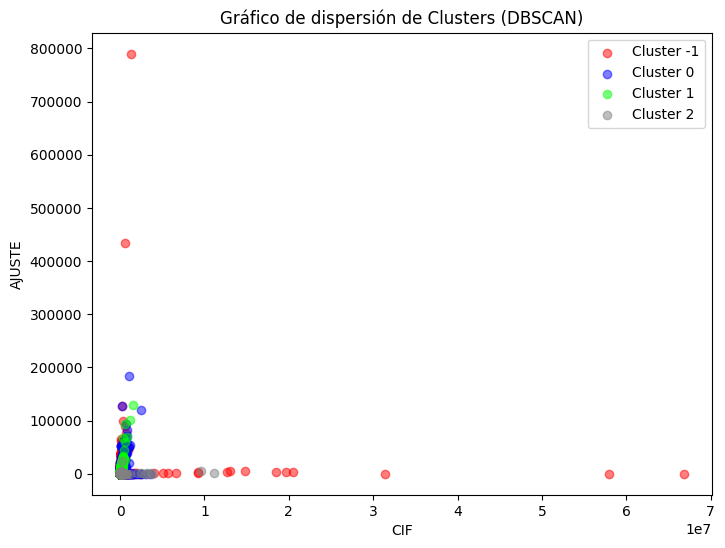

Archivo guardado exitosamente en C:/Mae_BI_UAM/M13/RN_Final/Evasion3/data/data.csv
   AJUSTE  TIEMPO       CIF       KILO     PAG  GRUPO
0     0.0   19.67   300.000    300.000  100.00     -1
1     0.0    4.89  1879.465    382.004  247.52      0
2     0.0   67.48   300.000  32897.564  100.00     -1
3     0.0    8.77   300.000  32897.564  100.00     -1
4     0.0    4.98   300.000  32897.564  100.00      1


In [13]:
# Clustering para segentar a los operadores segun el valor importado y nivel de ajuste o evasion
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Configurar variables de entorno para limitar el número de subprocesos
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

# Leer el archivo BaseRN.xlsx
df = pd.read_excel('C:/Mae_BI_UAM/M13/RN_Final/Evasion3/data/BaseRN.xlsx')

# Agrupar por ID_C y calcular las estadísticas
B_clustering = df.groupby('ID_C').agg({
    'ID_C': 'size',     # Contar el número de ocurrencias de ID_C
    'TIEMPO': 'mean',   # Calcular la media de TIEMPO
    'CIF': 'sum',       # Calcular la suma de CIF
    'KILO': 'sum',      # Calcular la suma de KILO
    'PAG': 'sum',       # Calcular la suma de PAG
    'AJUSTE': 'sum'     # Calcular la suma de AJUSTE
}).rename(columns={'ID_C': 'DUC'}).reset_index()

# Seleccionar las variables para la clusterización
X = B_clustering[['CIF', 'AJUSTE']]

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  
B_clustering['GRUPO'] = dbscan.fit_predict(X_scaled)

# Añadir los Clustering al dataset original
df = df.merge(B_clustering[['ID_C', 'GRUPO']], on='ID_C', how='left')

# Guardar el nuevo DataFrame con la columna GRUPO
output_path = 'C:/Mae_BI_UAM/M13/RN_Final/Evasion3/data/BaseRN_Clustering.xlsx'
df.to_excel(output_path, index=False)

print(f"Clustering completado y guardado en {output_path}")

# Conociendo la cantidad de Clustering generados y su etiqueta
# Leer el archivo BaseRN_Clustering.xlsx
df = pd.read_excel(output_path)

# Contar el número de clusters únicos
clusters_unicos = df['GRUPO'].nunique()
print(f"Número de clusters generados: {clusters_unicos}")

# Mostrar los nombres o etiquetas de los clusters únicos
clusters_labels = df['GRUPO'].unique()
print(f"Etiquetas de los clusters: {clusters_labels}")
# -1 puntos considerados como ruidos
# 0 operaciones con menor valor importado y menor ajuste
# 1 operaciones con mayor valor importado y mayor ajuste

# Graficar los puntos de datos coloreados por cluster
plt.figure(figsize=(8, 6))

# Definir colores para cada cluster
colors = {-1: 'red', 0: 'blue', 1: 'lime'}

# Iterar sobre cada cluster y graficar los puntos correspondientes
for cluster_label in clusters_labels:
    color = colors.get(cluster_label, 'gray')  # Asignar gris por defecto para etiquetas no definidas
    plt.scatter(df.loc[df['GRUPO'] == cluster_label, 'CIF'], 
                df.loc[df['GRUPO'] == cluster_label, 'AJUSTE'], 
                color=color, label=f'Cluster {cluster_label}', alpha=0.5)

plt.xlabel('CIF')
plt.ylabel('AJUSTE')
plt.title('Gráfico de dispersión de Clusters (DBSCAN)')
plt.legend()
plt.show()

# Seleccionando las variables para el modelo
# Leer el archivo BaseRN_Clustering.xlsx
df = pd.read_excel(output_path)

# Seleccionar las variables requeridas: AJUSTE, TIEMPO, CIF, KILO, PAG, GRUPO
data = df[['AJUSTE', 'TIEMPO', 'CIF', 'KILO', 'PAG', 'GRUPO']]

# Especificar la ruta para guardar el archivo
ruta_guardado = 'C:/Mae_BI_UAM/M13/RN_Final/Evasion3/data/data.csv'

# Guardar el DataFrame en formato CSV en la ubicación especificada
data.to_csv(ruta_guardado, index=False)

print(f"Archivo guardado exitosamente en {ruta_guardado}")

# Mostrar los primeros 5 registros de la base de datos data
primeros_registros = data.head()
print(primeros_registros)

In [16]:
# CORRIDA # 2 MODELO MLP CON 2 capas OCULTAS
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import os
from math import sqrt

# Cargar el script de neuronas
neuronas_script_path = 'C:/Mae_BI_UAM/M13/RN_Final/Evasion3/libs/neuronas.py'
exec(open(neuronas_script_path).read())

# Cargar los datos
data_path = 'C:/Mae_BI_UAM/M13/RN_Final/Evasion3/data/data.csv'
data = pd.read_csv(data_path)

# Mostrar las primeras filas del conjunto de datos
print(data.head())

# Convertir la variable categórica 'GRUPO' a factores
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Separar las características y la variable objetivo
X = data.drop(columns=['AJUSTE'])
y = data['AJUSTE']

# Normalizar los datos
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Separar el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Función para calcular las métricas de rendimiento
def calcular_metricas(y_real, y_pred):
    mse = mean_squared_error(y_real, y_pred)
    rmse = sqrt(mse)
    mae = mean_absolute_error(y_real, y_pred)
    return mse, rmse, mae

# Escenario base: 20 neuronas por capa oculta, 0.05 tasa de aprendizaje, 500 épocas
escenario_base = (20, 20, 0.05, 500)
RNA_MLP_base = MLP([X_train.shape[1], escenario_base[0], escenario_base[1], 1])
RNA_MLP_base.train(X_train, y_train.values, escenario_base[2], escenario_base[3])

predicciones_train_base = RNA_MLP_base.feedforward(X_train).flatten()
predicciones_test_base = RNA_MLP_base.feedforward(X_test).flatten()

mse_train_base, rmse_train_base, mae_train_base = calcular_metricas(y_train, predicciones_train_base)
mse_test_base, rmse_test_base, mae_test_base = calcular_metricas(y_test, predicciones_test_base)

print(f"Escenario Base: Neuronas={escenario_base[0]}, Neuronas2={escenario_base[1]}, Tasa de aprendizaje={escenario_base[2]}, Épocas={escenario_base[3]}")
print(f"RMSE Train: {rmse_train_base}, RMSE Test: {rmse_test_base}")
print(f"MAE Train: {mae_train_base}, MAE Test: {mae_test_base}\n")

# Resto de los escenarios con tasas de aprendizaje adicionales (excluyendo 0.01)
tasas_aprendizaje = [0.025, 0.001]
configuraciones = [(8, 8, tasa, 5) for tasa in tasas_aprendizaje] + \
                  [(12, 12, tasa, 5) for tasa in tasas_aprendizaje] + \
                  [(18, 18, tasa, 5) for tasa in tasas_aprendizaje] + \
                  [(25, 25, tasa, 5) for tasa in tasas_aprendizaje] + \
                  [(30, 30, tasa, 5) for tasa in tasas_aprendizaje] + \
                  [(8, 8, tasa, 5) for tasa in tasas_aprendizaje] + \
                  [(12, 12, tasa, 10) for tasa in tasas_aprendizaje] + \
                  [(18, 18, tasa, 10) for tasa in tasas_aprendizaje] + \
                  [(20, 20, tasa, 10) for tasa in tasas_aprendizaje] + \
                  [(25, 25, tasa, 10) for tasa in tasas_aprendizaje] + \
                  [(30, 30, tasa, 10) for tasa in tasas_aprendizaje]

resultados = [(0, escenario_base[0], escenario_base[1], escenario_base[2], escenario_base[3], mse_train_base, rmse_train_base, mae_train_base, mse_test_base, rmse_test_base, mae_test_base)]
predicciones_totales = [pd.DataFrame({
    'Escenario': [0] * len(y_test),
    'Valor Real': y_test.values,
    'Predicción': predicciones_test_base
})]

for i, (neuronas, neuronas2, tasa_aprendizaje, epocas) in enumerate(configuraciones, start=1):
    RNA_MLP = MLP([X_train.shape[1], neuronas, neuronas2, 1])
    RNA_MLP.train(X_train, y_train.values, tasa_aprendizaje, epocas)
    predicciones_train = RNA_MLP.feedforward(X_train).flatten()
    predicciones_test = RNA_MLP.feedforward(X_test).flatten()

    mse_train, rmse_train, mae_train = calcular_metricas(y_train, predicciones_train)
    mse_test, rmse_test, mae_test = calcular_metricas(y_test, predicciones_test)

    resultados.append((i, neuronas, neuronas2, tasa_aprendizaje, epocas, mse_train, rmse_train, mae_train, mse_test, rmse_test, mae_test))
    predicciones_totales.append(pd.DataFrame({
        'Escenario': [i] * len(y_test),
        'Valor Real': y_test.values,
        'Predicción': predicciones_test
    }))

    print(f"Escenario {i}: Neuronas={neuronas}, Neuronas2={neuronas2}, Tasa de aprendizaje={tasa_aprendizaje}, Épocas={epocas}")
    print(f"RMSE Train: {rmse_train}, RMSE Test: {rmse_test}")
    print(f"MAE Train: {mae_train}, MAE Test: {mae_test}\n")


   AJUSTE  TIEMPO       CIF       KILO     PAG  GRUPO
0     0.0   19.67   300.000    300.000  100.00     -1
1     0.0    4.89  1879.465    382.004  247.52      0
2     0.0   67.48   300.000  32897.564  100.00     -1
3     0.0    8.77   300.000  32897.564  100.00     -1
4     0.0    4.98   300.000  32897.564  100.00      1
Escenario Base: Neuronas=20, Neuronas2=20, Tasa de aprendizaje=0.05, Épocas=500
RMSE Train: 5322.721048263929, RMSE Test: 3262.711929745522
MAE Train: 834.6639695910334, MAE Test: 812.5188197390167

Escenario 1: Neuronas=8, Neuronas2=8, Tasa de aprendizaje=0.025, Épocas=5
RMSE Train: 5322.721048263929, RMSE Test: 3262.711929745522
MAE Train: 834.6639695910334, MAE Test: 812.5188197390167

Escenario 2: Neuronas=8, Neuronas2=8, Tasa de aprendizaje=0.001, Épocas=5
RMSE Train: 5322.721048263929, RMSE Test: 3262.711929745522
MAE Train: 834.6639695910334, MAE Test: 812.5188197390167

Escenario 3: Neuronas=12, Neuronas2=12, Tasa de aprendizaje=0.025, Épocas=5
RMSE Train: 532

Epoch 1/100


C:\Users\wbonilla\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\wbonilla\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 815us/step - loss: 7772717.0000 - mean_absolute_error: 542.7602 - val_loss: 304514.9688 - val_mean_absolute_error: 229.4485 - learning_rate: 0.0100
Epoch 2/100
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 779us/step - loss: 10451623.0000 - mean_absolute_error: 446.5812 - val_loss: 526306.9375 - val_mean_absolute_error: 294.7103 - learning_rate: 0.0100
Epoch 3/100
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step - loss: 3329922.0000 - mean_absolute_error: 398.7490 - val_loss: 757333.8750 - val_mean_absolute_error: 375.0373 - learning_rate: 0.0100
Epoch 4/100
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 754us/step - loss: 3631621.2500 - mean_absolute_error: 457.8979 - val_loss: 2426233.7500 - val_mean_absolute_error: 475.1332 - learning_rate: 0.0100
Epoch 5/100
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 822us/step - loss: 4068307.5000 - mean_absolute_error: 442.9012 - val_loss: 3369790.0000 - val_mean_absolute_error: 449.8575 - learning_rate: 0.0100
Epoch 6/100
1200/1200 ━━━━━━━━━━━━━━━━━

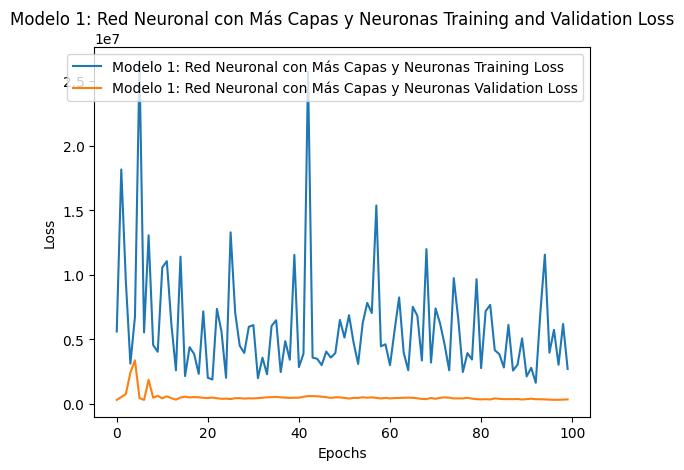

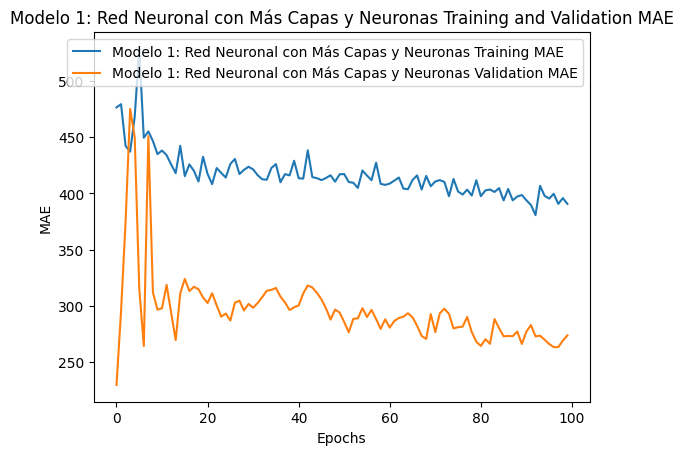

Epoch 1/100
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 982us/step - loss: 11109307.0000 - mean_absolute_error: 764.5990 - val_loss: 1363833.0000 - val_mean_absolute_error: 236.9886 - learning_rate: 0.0100
Epoch 2/100
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 890us/step - loss: 10124772.0000 - mean_absolute_error: 344.8704 - val_loss: 725142.2500 - val_mean_absolute_error: 212.5754 - learning_rate: 0.0100
Epoch 3/100
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 898us/step - loss: 3566493.7500 - mean_absolute_error: 296.1583 - val_loss: 638110.5000 - val_mean_absolute_error: 236.5955 - learning_rate: 0.0100
Epoch 4/100
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 901us/step - loss: 3715623.2500 - mean_absolute_error: 336.2151 - val_loss: 332879.0938 - val_mean_absolute_error: 275.2758 - learning_rate: 0.0100
Epoch 5/100
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 863us/step - loss: 2145656.7500 - mean_absolute_error: 303.0217 - val_loss: 268677.1250 - val_mean_absolute_error: 221.1418 - learning_rate: 0.0100
Epoch 6/100
1200/1200 ━━━━━

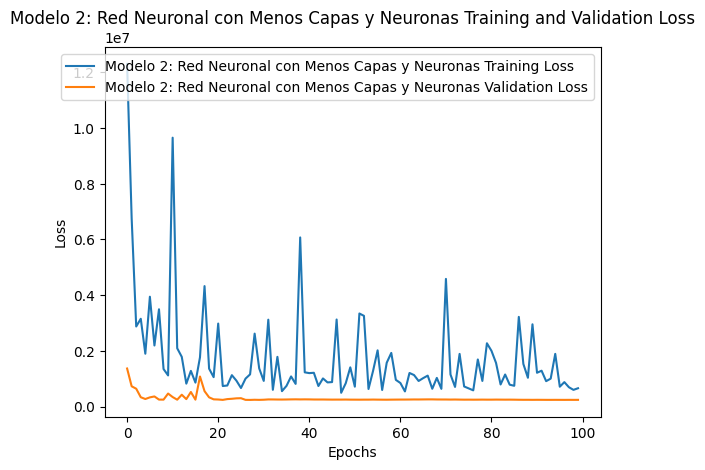

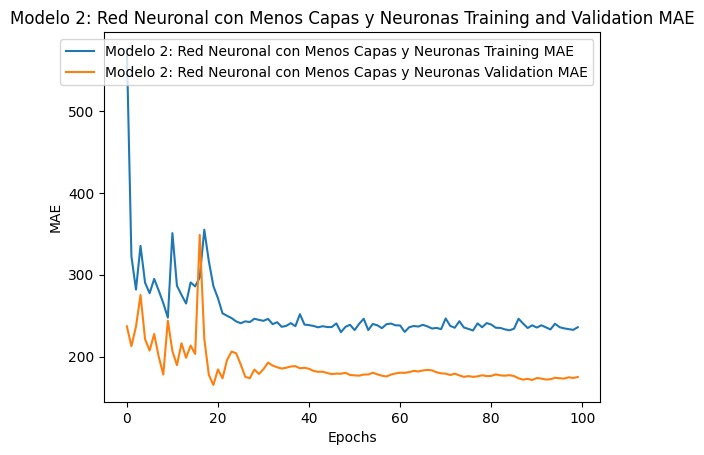

Epoch 1/100
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 9878450.0000 - mean_absolute_error: 690.2853 - val_loss: 553754.1250 - val_mean_absolute_error: 254.9086 - learning_rate: 0.0100
Epoch 2/100
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2979447.2500 - mean_absolute_error: 416.8991 - val_loss: 1169062.5000 - val_mean_absolute_error: 416.7344 - learning_rate: 0.0100
Epoch 3/100
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 12937139.0000 - mean_absolute_error: 506.9233 - val_loss: 344067.4062 - val_mean_absolute_error: 270.7769 - learning_rate: 0.0100
Epoch 4/100
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4401355.0000 - mean_absolute_error: 385.9281 - val_loss: 370381.5312 - val_mean_absolute_error: 292.6366 - learning_rate: 0.0100
Epoch 5/100
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1198154.6250 - mean_absolute_error: 346.5141 - val_loss: 430531.5312 - val_mean_absolute_error: 267.8452 - learning_rate: 0.0100
Epoch 6/100
1200/1200 ━━━━━━━━━━━━━━━━

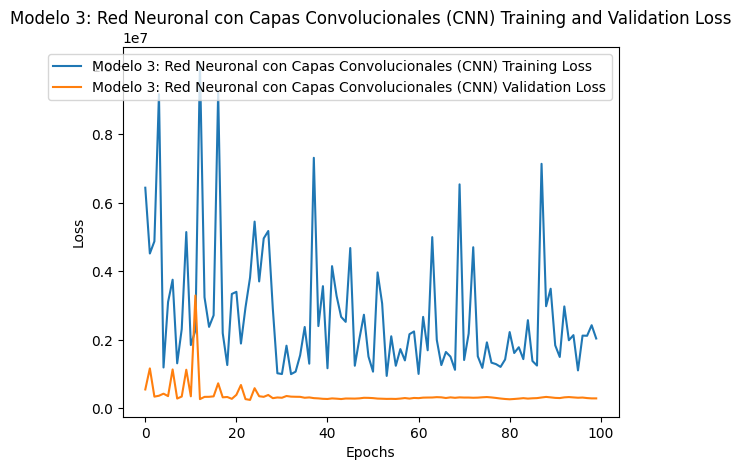

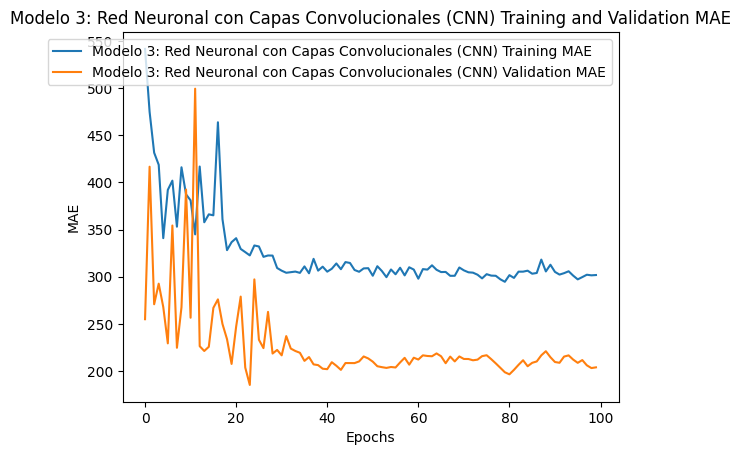

                                                    Train RMSE   Train MAE  \
Modelo                                                                       
Modelo 1: Red Neuronal con Más Capas y Neuronas     583.200384  270.703918   
Modelo 2: Red Neuronal con Menos Capas y Neuronas   442.326378  170.297028   
Modelo 3: Red Neuronal con Capas Convolucionale...  579.650811  201.952438   

                                                    Train MAPE   Test RMSE  \
Modelo                                                                       
Modelo 1: Red Neuronal con Más Capas y Neuronas            inf  536.786940   
Modelo 2: Red Neuronal con Menos Capas y Neuronas          inf  405.021971   
Modelo 3: Red Neuronal con Capas Convolucionale...         inf  478.126797   

                                                      Test MAE  Test MAPE  
Modelo                                                                     
Modelo 1: Red Neuronal con Más Capas y Neuronas     266.429565    

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


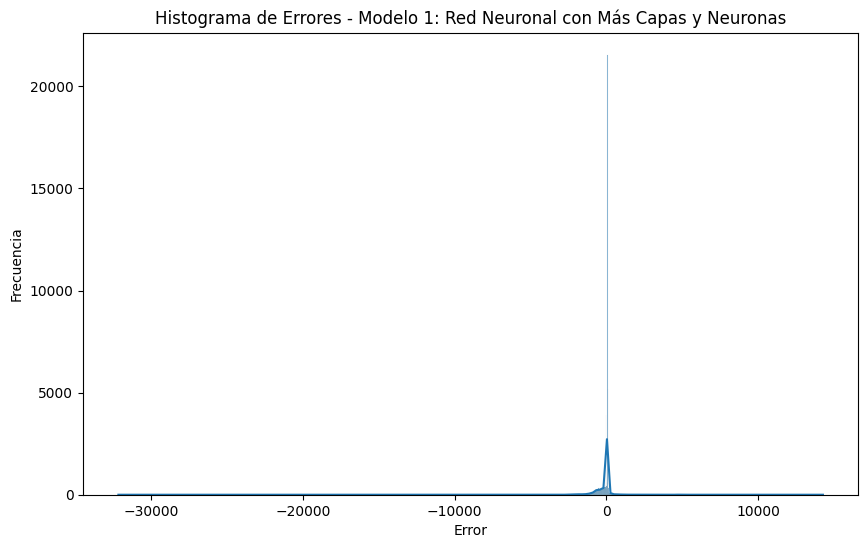

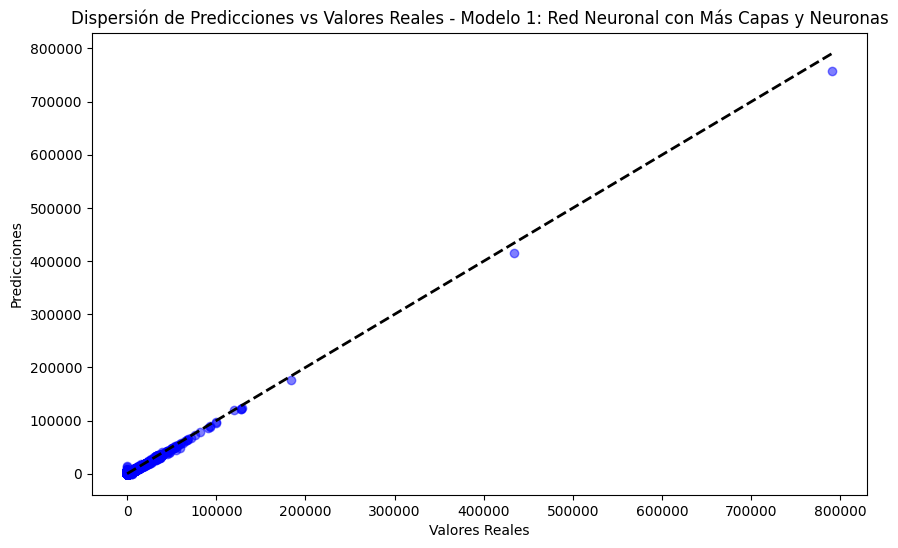

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


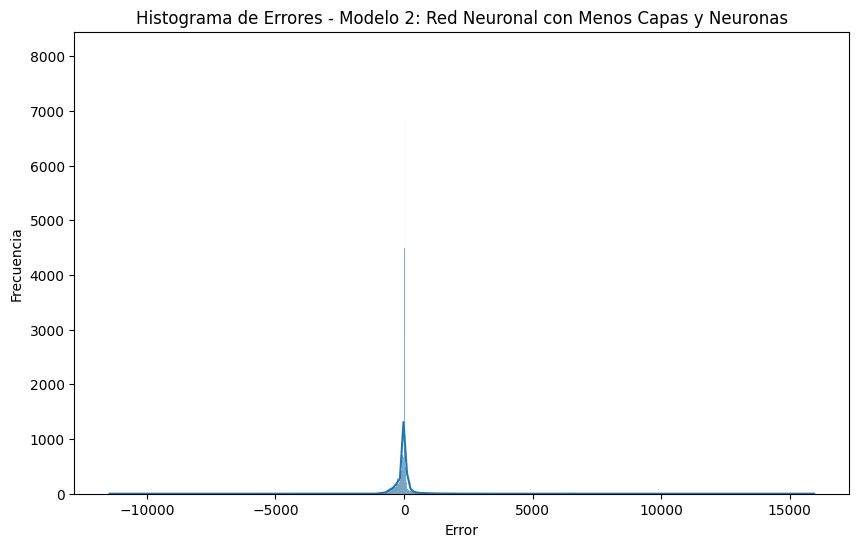

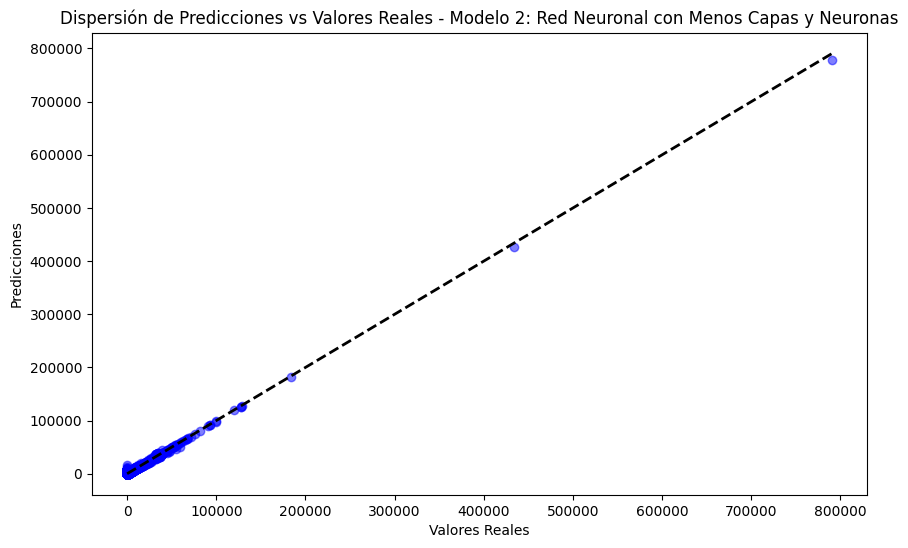

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


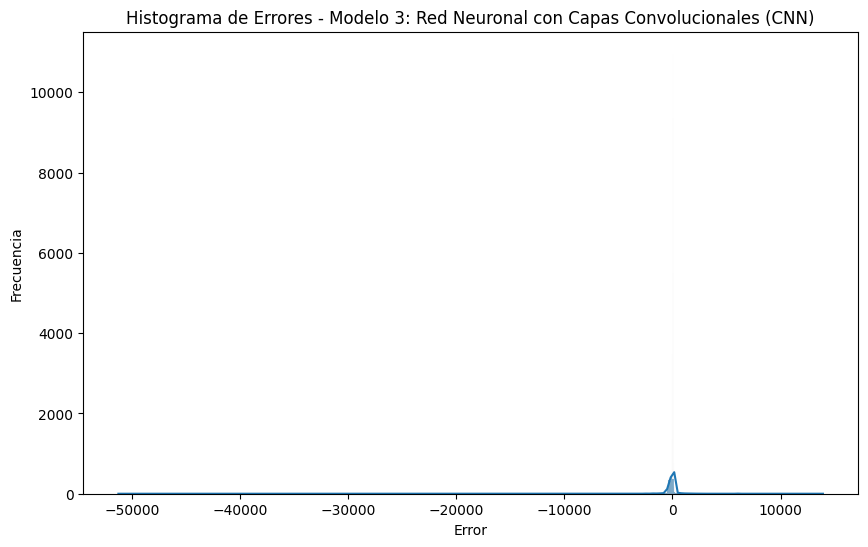

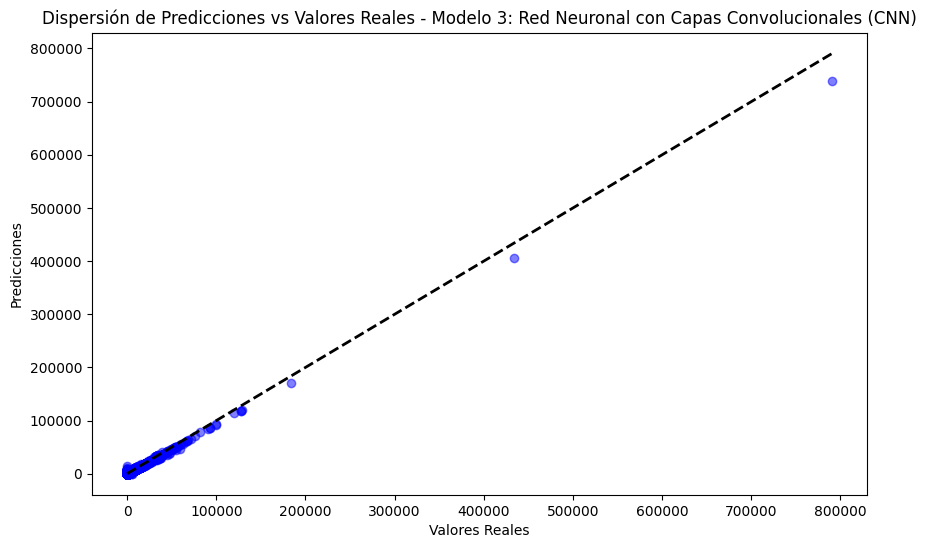

In [6]:
# CORRIDA 3 MODELOS MLP NULTICAPAS Y RES CNN
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Cargar los datos
data_path = 'C:/Mae_BI_UAM/M13/RN_Final/Evasion3/data/data.csv'
data = pd.read_csv(data_path)

# Convertir variables categóricas a numéricas
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Verificar y manejar NaN en 'AJUSTE'
if data['AJUSTE'].isnull().sum() > 0:
    data.dropna(subset=['AJUSTE'], inplace=True)

# Separar características y objetivo
X = data.drop(columns=['AJUSTE'])
y = data['AJUSTE']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Crear los modelos
def create_model_1(input_dim, initializer='he_normal'):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu', kernel_initializer=initializer))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_initializer=initializer))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu', kernel_initializer=initializer))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu', kernel_initializer=initializer))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='linear'))
    return model

def create_model_2(input_dim, initializer='he_normal'):
    model = Sequential()
    model.add(Dense(32, input_dim=input_dim, activation='relu', kernel_initializer=initializer))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu', kernel_initializer=initializer))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    return model

def create_model_3(input_dim, initializer='he_normal'):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(input_dim, 1)))
    model.add(Dropout(0.2))
    model.add(Conv1D(16, kernel_size=3, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(16, activation='relu', kernel_initializer=initializer))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    return model

# Lista de modelos y sus nombres
models = [create_model_1(X_train.shape[1]), create_model_2(X_train.shape[1]), create_model_3(X_train.shape[1])]
model_names = [
    'Modelo 1: Red Neuronal con Más Capas y Neuronas',
    'Modelo 2: Red Neuronal con Menos Capas y Neuronas',
    'Modelo 3: Red Neuronal con Capas Convolucionales (CNN)'
]

# Compilar y entrenar cada modelo
results = []
data_predic = data.copy()

for i, (model, name) in enumerate(zip(models, model_names), start=1):
    optimizer = Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])
    
    # Callback para reducir la tasa de aprendizaje si no hay mejora
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
    
    # Redimensionar los datos para el modelo convolucional
    if "Convolucionales" in name:
        X_train_conv = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_test_conv = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
        history = model.fit(X_train_conv, y_train, 
                            epochs=100, 
                            batch_size=32, 
                            validation_split=0.2, 
                            callbacks=[reduce_lr],
                            verbose=1)
    else:
        history = model.fit(X_train, y_train, 
                            epochs=100, 
                            batch_size=32, 
                            validation_split=0.2, 
                            callbacks=[reduce_lr],
                            verbose=1)
    
    # Evaluar el modelo
    if "Convolucionales" in name:
        train_loss, train_mae = model.evaluate(X_train_conv, y_train, verbose=0)
        test_loss, test_mae = model.evaluate(X_test_conv, y_test, verbose=0)
    else:
        train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
        test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    
    # Calcular MAPE
    if "Convolucionales" in name:
        y_train_pred = model.predict(X_train_conv)
        y_test_pred = model.predict(X_test_conv)
    else:
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
    
    train_mape = np.mean(np.abs((y_train - y_train_pred.flatten()) / y_train)) * 100
    test_mape = np.mean(np.abs((y_test - y_test_pred.flatten()) / y_test)) * 100
    
    results.append((name, np.sqrt(train_loss), train_mae, train_mape, np.sqrt(test_loss), test_mae, test_mape))
    
    # Guardar las predicciones en un nuevo DataFrame
    pred_column_name = f'Prediccion_Ajuste_{name}'
    if "Convolucionales" in name:
        data_predic[pred_column_name] = model.predict(scaler.transform(data.drop(columns=['AJUSTE'])).reshape(-1, X_train.shape[1], 1)).flatten()
    else:
        data_predic[pred_column_name] = model.predict(scaler.transform(data.drop(columns=['AJUSTE']))).flatten()
    
    # Graficar la pérdida durante el entrenamiento
    plt.plot(history.history['loss'], label=f'{name} Training Loss')
    plt.plot(history.history['val_loss'], label=f'{name} Validation Loss')
    plt.title(f'{name} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Graficar el MAE durante el entrenamiento
    plt.plot(history.history['mean_absolute_error'], label=f'{name} Training MAE')
    plt.plot(history.history['val_mean_absolute_error'], label=f'{name} Validation MAE')
    plt.title(f'{name} Training and Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()
    
    # Guardar el modelo
    model.save(f'C:/Mae_BI_UAM/M13/RN_Final/Evasion3/data/Modelo{i}.h5')

# Guardar los datos con predicciones
data_predic.to_csv('C:/Mae_BI_UAM/M13/RN_Final/Evasion3/data/1BASE_SIEC_com_predicciones.csv', index=False)

# Mostrar resultados en formato de tabla
Resultados_modelos = pd.DataFrame(results, columns=['Modelo', 'Train RMSE', 'Train MAE', 'Train MAPE', 'Test RMSE', 'Test MAE', 'Test MAPE'])
Resultados_modelos.set_index('Modelo', inplace=True)

# Guardar el DataFrame en la dirección especificada
output_path = 'C:/Mae_BI_UAM/M13/RN_Final/Evasion3/data/Resultados_modelos.csv'
Resultados_modelos.to_csv(output_path)

# Imprimir resultados
print(Resultados_modelos)

# Seleccionar el mejor modelo basado en el Test RMSE
best_model = Resultados_modelos['Test RMSE'].idxmin()
print(f"\nEl mejor modelo basado en Test RMSE es: {best_model}")
print(f"Este modelo se selecciona porque tiene el menor valor de Test RMSE ({Resultados_modelos.loc[best_model, 'Test RMSE']}),")
print(f"lo que indica que tiene el mejor rendimiento en el conjunto de prueba en términos de error cuadrático medio.")

# Graficar los errores y la dispersión
for model_name in model_names:
    pred_column = f'Prediccion_Ajuste_{model_name}'
    if pred_column in data_predic.columns:
        data_predic[f'Error_{model_name}'] = data_predic[pred_column] - data_predic['AJUSTE']
        
        # Histograma de errores
        plt.figure(figsize=(10, 6))
        sns.histplot(data_predic[f'Error_{model_name}'], kde=True)
        plt.title(f'Histograma de Errores - {model_name}')
        plt.xlabel('Error')
        plt.ylabel('Frecuencia')
        plt.show()
        
        # Gráfico de dispersión
        plt.figure(figsize=(10, 6))
        plt.scatter(data_predic['AJUSTE'], data_predic[pred_column], alpha=0.5, color='b')
        plt.plot([data_predic['AJUSTE'].min(), data_predic['AJUSTE'].max()], 
                 [data_predic['AJUSTE'].min(), data_predic['AJUSTE'].max()], 'k--', lw=2)
        plt.title(f'Dispersión de Predicciones vs Valores Reales - {model_name}')
        plt.xlabel('Valores Reales')
        plt.ylabel('Predicciones')
        plt.show()



In [1]:
##  COMPARATIVO DE PREDICCION POR MODELO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Cargar los datos
data_path = 'C:/Mae_BI_UAM/M13/RN_Final/Evasion3/data/data.csv'
data = pd.read_csv(data_path)

# Convertir variables categóricas a numéricas
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Verificar y manejar NaN en 'AJUSTE'
if data['AJUSTE'].isnull().sum() > 0:
    data.dropna(subset=['AJUSTE'], inplace=True)

# Separar características y objetivo
X = data.drop(columns=['AJUSTE'])
y = data['AJUSTE']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Crear los modelos
def create_model_1(input_dim, initializer='he_normal'):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu', kernel_initializer=initializer))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_initializer=initializer))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu', kernel_initializer=initializer))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu', kernel_initializer=initializer))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='linear'))
    return model

def create_model_2(input_dim, initializer='he_normal'):
    model = Sequential()
    model.add(Dense(32, input_dim=input_dim, activation='relu', kernel_initializer=initializer))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu', kernel_initializer=initializer))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    return model

def create_model_3(input_dim, initializer='he_normal'):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(input_dim, 1)))
    model.add(Dropout(0.2))
    model.add(Conv1D(16, kernel_size=3, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(16, activation='relu', kernel_initializer=initializer))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    return model

# Lista de modelos y sus nombres
models = [create_model_1(X_train.shape[1]), create_model_2(X_train.shape[1]), create_model_3(X_train.shape[1])]
model_names = [
    'Modelo 1: Red Neuronal con Más Capas y Neuronas',
    'Modelo 2: Red Neuronal con Menos Capas y Neuronas',
    'Modelo 3: Red Neuronal con Capas Convolucionales (CNN)'
]

# Compilar y entrenar cada modelo
results = []
data_predic = data.copy()

train_predictions = pd.DataFrame(y_train.values, columns=['AJUSTE'])
test_predictions = pd.DataFrame(y_test.values, columns=['AJUSTE'])

for model, name in zip(models, model_names):
    optimizer = Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])
    
    # Callback para reducir la tasa de aprendizaje si no hay mejora
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
    
    # Redimensionar los datos para el modelo convolucional
    if "Convolucionales" in name:
        X_train_conv = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_test_conv = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
        history = model.fit(X_train_conv, y_train, 
                            epochs=100, 
                            batch_size=32, 
                            validation_split=0.2, 
                            callbacks=[reduce_lr],
                            verbose=1)
    else:
        history = model.fit(X_train, y_train, 
                            epochs=100, 
                            batch_size=32, 
                            validation_split=0.2, 
                            callbacks=[reduce_lr],
                            verbose=1)
    
    # Guardar las predicciones en el DataFrame correspondiente
    pred_column_name = f'Prediccion_Ajuste_{name}'
    if "Convolucionales" in name:
        train_predictions[pred_column_name] = model.predict(X_train_conv).flatten()
        test_predictions[pred_column_name] = model.predict(X_test_conv).flatten()
    else:
        train_predictions[pred_column_name] = model.predict(X_train).flatten()
        test_predictions[pred_column_name] = model.predict(X_test).flatten()

# Guardar los DataFrames comparativos en archivos CSV
train_output_path = 'C:/Mae_BI_UAM/M13/RN_Final/Evasion3/data/E_Comparativo_ajuste.csv'
test_output_path = 'C:/Mae_BI_UAM/M13/RN_Final/Evasion3/data/T_Comparativo_ajuste.csv'

train_predictions.to_csv(train_output_path, index=False)
test_predictions.to_csv(test_output_path, index=False)

# Mostrar los primeros 50 registros del DataFrame de prueba
print(test_predictions.head(50))

Epoch 1/100


C:\Users\wbonilla\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\wbonilla\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 807us/step - loss: 7972111.5000 - mean_absolute_error: 485.4158 - val_loss: 452000.4688 - val_mean_absolute_error: 298.0823 - learning_rate: 0.0100
Epoch 2/100
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/step - loss: 2078358.3750 - mean_absolute_error: 376.9185 - val_loss: 4330829.0000 - val_mean_absolute_error: 550.0068 - learning_rate: 0.0100
Epoch 3/100
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/step - loss: 5851080.0000 - mean_absolute_error: 558.7503 - val_loss: 499439.7188 - val_mean_absolute_error: 294.7645 - learning_rate: 0.0100
Epoch 4/100
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 736us/step - loss: 3868209.5000 - mean_absolute_error: 456.0970 - val_loss: 1590059.3750 - val_mean_absolute_error: 528.0141 - learning_rate: 0.0100
Epoch 5/100
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 764us/step - loss: 14693662.0000 - mean_absolute_error: 570.2098 - val_loss: 2137774.2500 - val_mean_absolute_error: 457.6686 - learning_rate: 0.0100
Epoch 6/100
1200/1200 ━━━━━━━━━━━━━━━━

In [1]:
# VALIDACION CRUZADA
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Función para crear el modelo
def create_model(input_dim, initializer='he_normal'):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu', kernel_initializer=initializer))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_initializer=initializer))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu', kernel_initializer=initializer))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu', kernel_initializer=initializer))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='linear'))
    return model

# Cargar los datos
data_path = 'C:/Mae_BI_UAM/M13/RN_Final/Evasion3/data/data.csv'
data = pd.read_csv(data_path)

# Convertir variables categóricas a numéricas
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Verificar y manejar NaN en 'AJUSTE'
data.dropna(subset=['AJUSTE'], inplace=True)

# Separar características y objetivo
X = data.drop(columns=['AJUSTE']).values
y = data['AJUSTE'].values

# Normalizar los datos
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Configurar la validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = []
mae_scores = []

# DataFrames para almacenar las predicciones y los valores reales
train_comparison = pd.DataFrame()
test_comparison = pd.DataFrame()

# Ejecutar la validación cruzada
for fold, (train_index, val_index) in enumerate(kf.split(X)):
    X_train_k, X_val_k = X[train_index], X[val_index]
    y_train_k, y_val_k = y[train_index], y[val_index]
    
    model = create_model(X_train_k.shape[1])
    optimizer = Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])
    model.fit(X_train_k, y_train_k, epochs=100, batch_size=32, verbose=0)
    
    # Evaluar el modelo en el conjunto de validación
    mse, mae = model.evaluate(X_val_k, y_val_k, verbose=0)
    mse_scores.append(mse)
    mae_scores.append(mae)
    
    # Almacenar las predicciones y los valores reales
    y_train_pred = model.predict(X_train_k).flatten()
    y_val_pred = model.predict(X_val_k).flatten()
    
    train_comparison = pd.concat([train_comparison, pd.DataFrame({'Fold': fold + 1, 'Real': y_train_k, 'Predicted': y_train_pred})])
    test_comparison = pd.concat([test_comparison, pd.DataFrame({'Fold': fold + 1, 'Real': y_val_k, 'Predicted': y_val_pred})])

# Calcular las métricas promedio
mean_mse = np.mean(mse_scores)
mean_mae = np.mean(mae_scores)

print(f'Average MSE: {mean_mse}')
print(f'Average MAE: {mean_mae}')

# Guardar los resultados de la comparación en archivos CSV
train_comparison.to_csv('C:/Mae_BI_UAM/M13/RN_Final/Evasion3/data/E_Comparativo_ajuste.csv', index=False)
test_comparison.to_csv('C:/Mae_BI_UAM/M13/RN_Final/Evasion3/data/T_Comparativo_ajuste.csv', index=False)

# Mostrar los primeros 50 registros de T_Comparativo_ajuste
print(test_comparison.head(50))

# Comentarios sobre los resultados
print("\nComentarios sobre los resultados de la validación cruzada:")
print("1. La validación cruzada nos permitió evaluar el rendimiento del modelo en diferentes particiones del conjunto de datos, lo que proporciona una estimación más robusta de su capacidad de generalización.")
print(f"2. El promedio de MSE a lo largo de los 5 folds es {mean_mse:.4f}, lo que indica el error cuadrático medio promedio de las predicciones del modelo.")
print(f"3. El promedio de MAE a lo largo de los 5 folds es {mean_mae:.4f}, lo que indica el error absoluto medio promedio de las predicciones del modelo.")
print("4. Las métricas obtenidas sugieren que el modelo tiene un rendimiento consistente en diferentes subconjuntos del conjunto de datos, aunque puede haber cierta variabilidad en los errores de predicción entre los folds.")
print("5. Los DataFrames 'E_Comparativo_ajuste' y 'T_Comparativo_ajuste' contienen las predicciones y los valores reales para cada fold en los conjuntos de entrenamiento y validación, respectivamente, lo que permite un análisis detallado de la precisión del modelo.")


C:\Users\wbonilla\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 634us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 579us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 547us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 566us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 592us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step
Average MSE: 2175571.925
Average MAE: 371.2569580078125
    Fold  Real   Predicted
0      1   0.0  143.983429
1      1   0.0  143.983429
2      1   0.0  143.983429
3      1   0.0  143.983429
4      1   0.0  143.983429
5      1   0.0  143.983429
6      1   0.0  143.983429
7      1   0.0  143.983429
8      1   0.0  143.983429
9      1   0.0  143.983429
10     1   0.0  143.983429
11     1   0.0  143.983429
12     1   0.0  143.983429
13     1   0.0  143.983429
14     1   0.0  143.983429
15     1   0.0  143.983429
16     1   0.0  143.983429
17     1   0.0  14

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


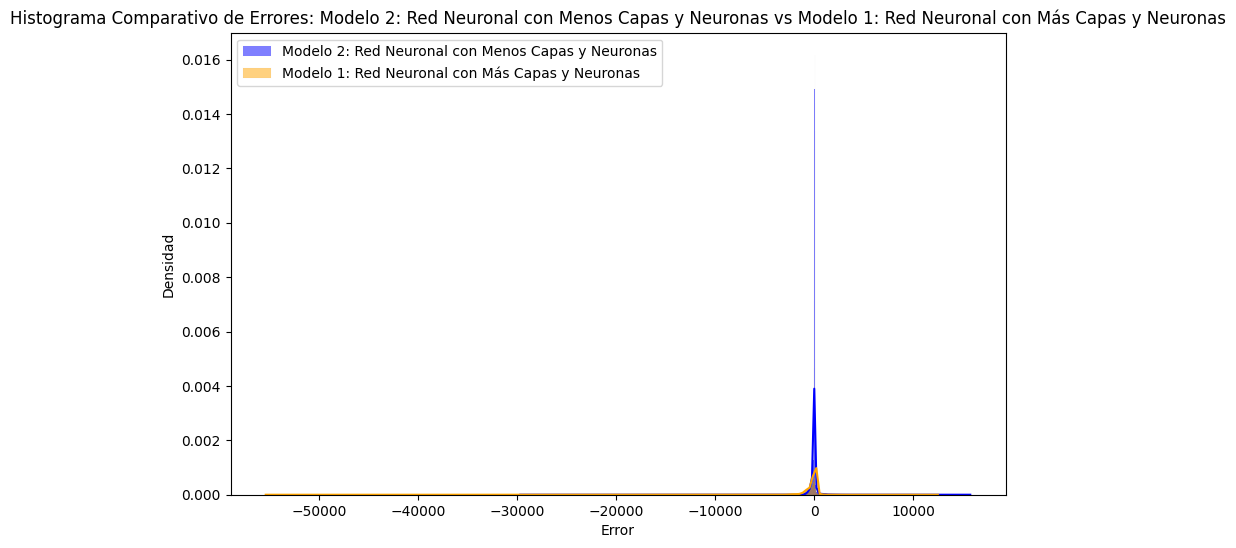

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


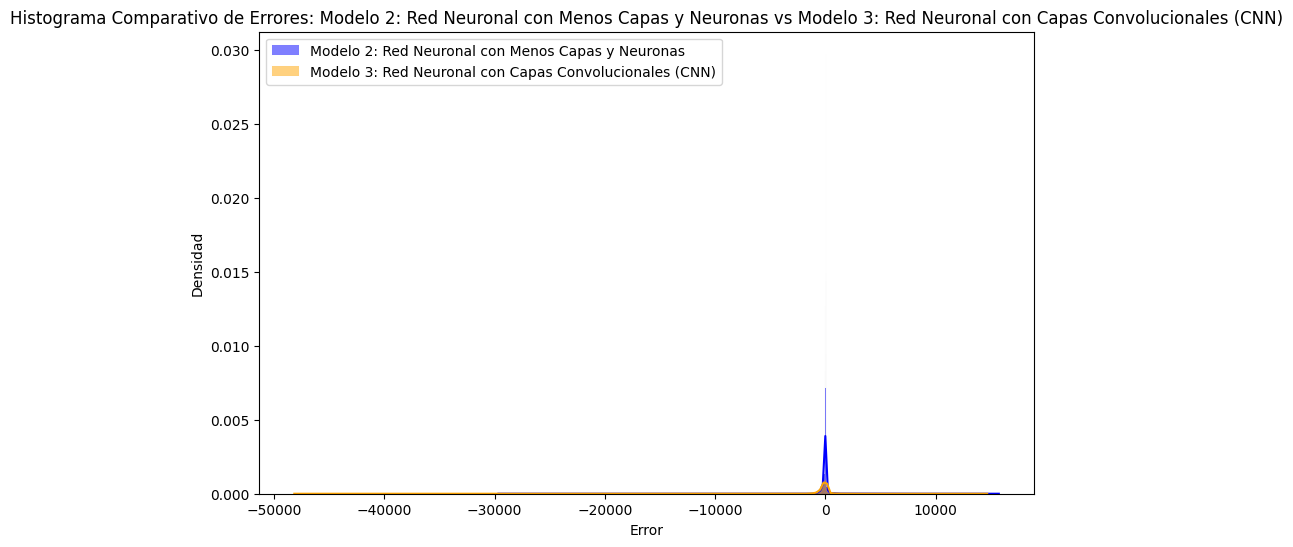

In [8]:
# GRAFICA HISTOGRAMA COMPARATIVO DE ERRORES
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ruta al archivo CSV que contiene las predicciones y los errores
data_predic_path = 'C:/Mae_BI_UAM/M13/RN_Final/Evasion3/data/1BASE_SIEC_com_predicciones.csv'

# Cargar el DataFrame `data_predic`
data_predic = pd.read_csv(data_predic_path)

# Lista de nombres de modelos y sus columnas de predicciones correspondientes
model_names = [
    'Modelo 1: Red Neuronal con Más Capas y Neuronas',
    'Modelo 2: Red Neuronal con Menos Capas y Neuronas',
    'Modelo 3: Red Neuronal con Capas Convolucionales (CNN)'
]

# Crear un diccionario para acceder rápidamente a los nombres de las columnas de predicciones
prediction_columns = {name: f'Prediccion_Ajuste_{name}' for name in model_names}

# Verificar que las columnas de predicciones existen en el DataFrame
for col in prediction_columns.values():
    if col not in data_predic.columns:
        raise ValueError(f"La columna {col} no se encuentra en el DataFrame data_predic.")

# Calcular los errores
for model_name in model_names:
    data_predic[f'Error_{model_name}'] = data_predic[prediction_columns[model_name]] - data_predic['AJUSTE']

# Graficar histogramas comparativos
comparisons = [
    ('Modelo 2: Red Neuronal con Menos Capas y Neuronas', 'Modelo 1: Red Neuronal con Más Capas y Neuronas'),
    ('Modelo 2: Red Neuronal con Menos Capas y Neuronas', 'Modelo 3: Red Neuronal con Capas Convolucionales (CNN)')
]

for model_base, model_compare in comparisons:
    plt.figure(figsize=(10, 6))
    sns.histplot(data_predic[f'Error_{model_base}'], color='blue', label=model_base, kde=True, stat="density", common_norm=False)
    sns.histplot(data_predic[f'Error_{model_compare}'], color='orange', label=model_compare, kde=True, stat="density", common_norm=False)
    plt.title(f'Histograma Comparativo de Errores: {model_base} vs {model_compare}')
    plt.xlabel('Error')
    plt.ylabel('Densidad')
    plt.legend()
    plt.show()


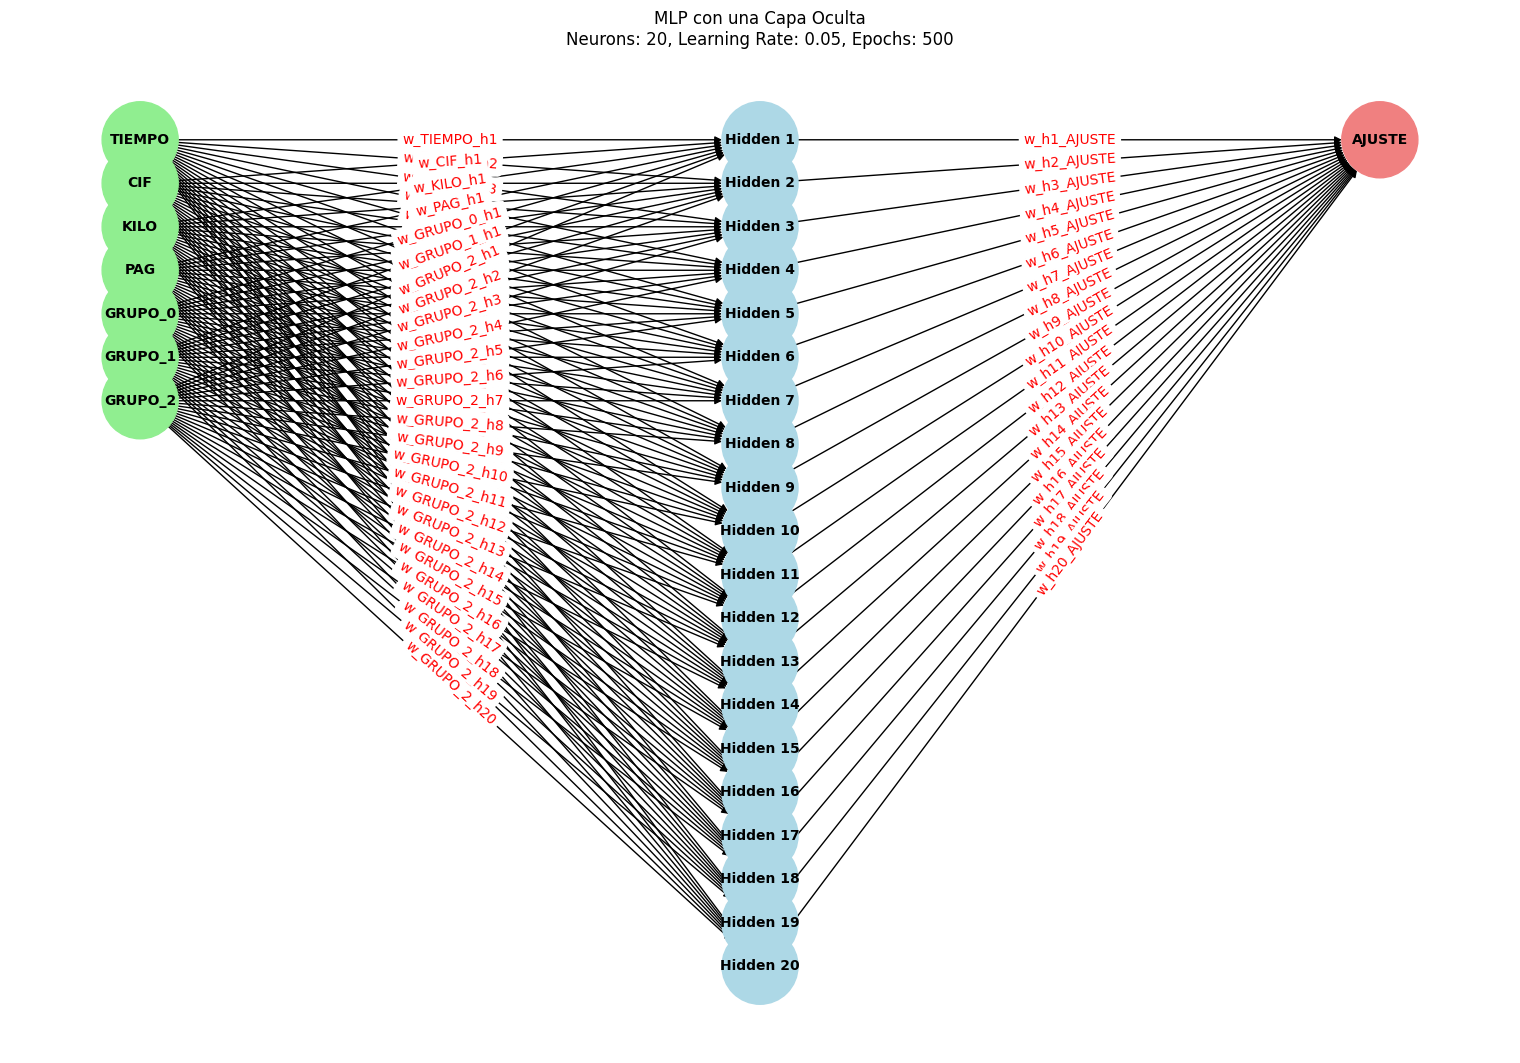

In [4]:
# GRAFICA DE RES MLP CON UNA CAPA OCULTA
import matplotlib.pyplot as plt
import networkx as nx

# Definir las neuronas de entrada basadas en las características especificadas
input_features = ['TIEMPO', 'CIF', 'KILO', 'PAG', 'GRUPO_0', 'GRUPO_1', 'GRUPO_2']  # Ajustar según el número de categorías en GRUPO
hidden_neurons = 20
output_neuron = 'AJUSTE'
learning_rate = 0.05
epochs = 500

# Crear el grafo
G = nx.DiGraph()

# Añadir nodos para la capa de entrada
for feature in input_features:
    G.add_node(feature, layer='input')

# Añadir nodos para la capa oculta
for i in range(hidden_neurons):
    G.add_node(f'Hidden {i+1}', layer='hidden')

# Añadir nodo para la capa de salida
G.add_node(output_neuron, layer='output')

# Conectar nodos de la capa de entrada a la capa oculta
for feature in input_features:
    for j in range(hidden_neurons):
        G.add_edge(feature, f'Hidden {j+1}', weight=f'w_{feature}_h{j+1}')

# Conectar nodos de la capa oculta a la capa de salida
for i in range(hidden_neurons):
    G.add_edge(f'Hidden {i+1}', output_neuron, weight=f'w_h{i+1}_{output_neuron}')

# Dibujar el grafo
pos = {}
pos.update((node, (0, -i)) for i, node in enumerate([n for n, d in G.nodes(data=True) if d['layer'] == 'input']))
pos.update((node, (1, -i)) for i, node in enumerate([n for n, d in G.nodes(data=True) if d['layer'] == 'hidden']))
pos.update((node, (2, -i)) for i, node in enumerate([n for n, d in G.nodes(data=True) if d['layer'] == 'output']))

plt.figure(figsize=(15, 10))

# Definir colores
node_colors = []
for node, data in G.nodes(data=True):
    if data['layer'] == 'input':
        node_colors.append('lightgreen')
    elif data['layer'] == 'hidden':
        node_colors.append('lightblue')
    else:
        node_colors.append('lightcoral')

nx.draw(G, pos, with_labels=True, node_size=3000, node_color=node_colors, font_size=10, font_weight='bold', arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['weight'] for u, v, d in G.edges(data=True)}, font_color='red')

plt.title(f'MLP con una Capa Oculta\nNeurons: {hidden_neurons}, Learning Rate: {learning_rate}, Epochs: {epochs}')
plt.show()

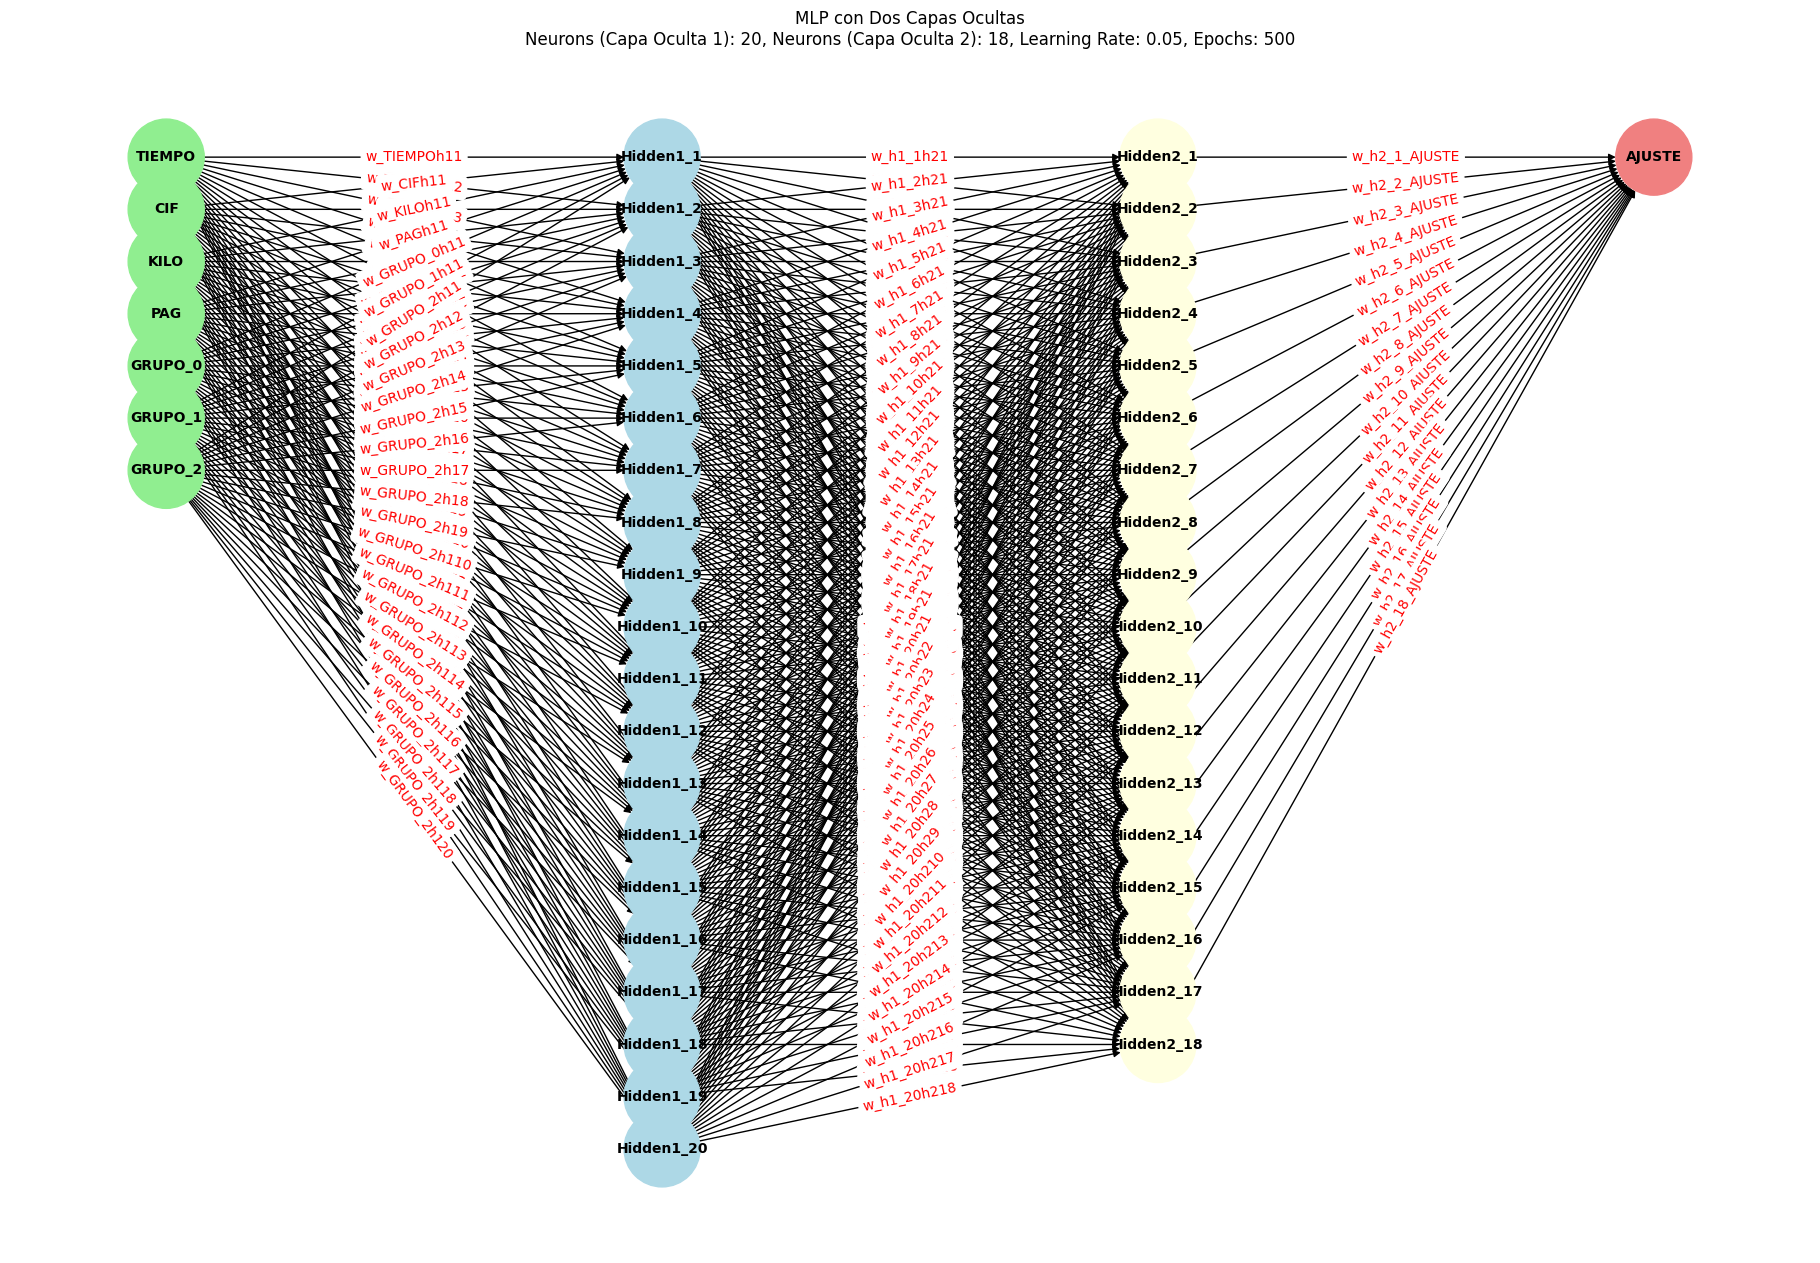

In [5]:
# GRAFICA DE RES MLP CON DOS CAPA OCULTA
import matplotlib.pyplot as plt
import networkx as nx

# Definir las neuronas de entrada basadas en las características especificadas
input_features = ['TIEMPO', 'CIF', 'KILO', 'PAG', 'GRUPO_0', 'GRUPO_1', 'GRUPO_2']  # Ajustar según el número de categorías en GRUPO
hidden_neurons1 = 20
hidden_neurons2 = 18
output_neuron = 'AJUSTE'
learning_rate = 0.05
epochs = 500

# Crear el grafo
G = nx.DiGraph()

# Añadir nodos para la capa de entrada
for feature in input_features:
    G.add_node(feature, layer='input')

# Añadir nodos para la primera capa oculta
for i in range(hidden_neurons1):
    G.add_node(f'Hidden1_{i+1}', layer='hidden1')

# Añadir nodos para la segunda capa oculta
for i in range(hidden_neurons2):
    G.add_node(f'Hidden2_{i+1}', layer='hidden2')

# Añadir nodo para la capa de salida
G.add_node(output_neuron, layer='output')

# Conectar nodos de la capa de entrada a la primera capa oculta
for feature in input_features:
    for j in range(hidden_neurons1):
        G.add_edge(feature, f'Hidden1_{j+1}', weight=f'w_{feature}h1{j+1}')

# Conectar nodos de la primera capa oculta a la segunda capa oculta
for i in range(hidden_neurons1):
    for j in range(hidden_neurons2):
        G.add_edge(f'Hidden1_{i+1}', f'Hidden2_{j+1}', weight=f'w_h1_{i+1}h2{j+1}')

# Conectar nodos de la segunda capa oculta a la capa de salida
for i in range(hidden_neurons2):
    G.add_edge(f'Hidden2_{i+1}', output_neuron, weight=f'w_h2_{i+1}_{output_neuron}')

# Dibujar el grafo
pos = {}
pos.update((node, (0, -i)) for i, node in enumerate([n for n, d in G.nodes(data=True) if d['layer'] == 'input']))
pos.update((node, (1, -i)) for i, node in enumerate([n for n, d in G.nodes(data=True) if d['layer'] == 'hidden1']))
pos.update((node, (2, -i)) for i, node in enumerate([n for n, d in G.nodes(data=True) if d['layer'] == 'hidden2']))
pos.update((node, (3, -i)) for i, node in enumerate([n for n, d in G.nodes(data=True) if d['layer'] == 'output']))

plt.figure(figsize=(18, 12))

# Definir colores
node_colors = []
for node, data in G.nodes(data=True):
    if data['layer'] == 'input':
        node_colors.append('lightgreen')
    elif data['layer'] == 'hidden1':
        node_colors.append('lightblue')
    elif data['layer'] == 'hidden2':
        node_colors.append('lightyellow')
    else:
        node_colors.append('lightcoral')

nx.draw(G, pos, with_labels=True, node_size=3000, node_color=node_colors, font_size=10, font_weight='bold', arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['weight'] for u, v, d in G.edges(data=True)}, font_color='red')

plt.title(f'MLP con Dos Capas Ocultas\nNeurons (Capa Oculta 1): {hidden_neurons1}, Neurons (Capa Oculta 2): {hidden_neurons2}, Learning Rate: {learning_rate}, Epochs: {epochs}')
plt.show()

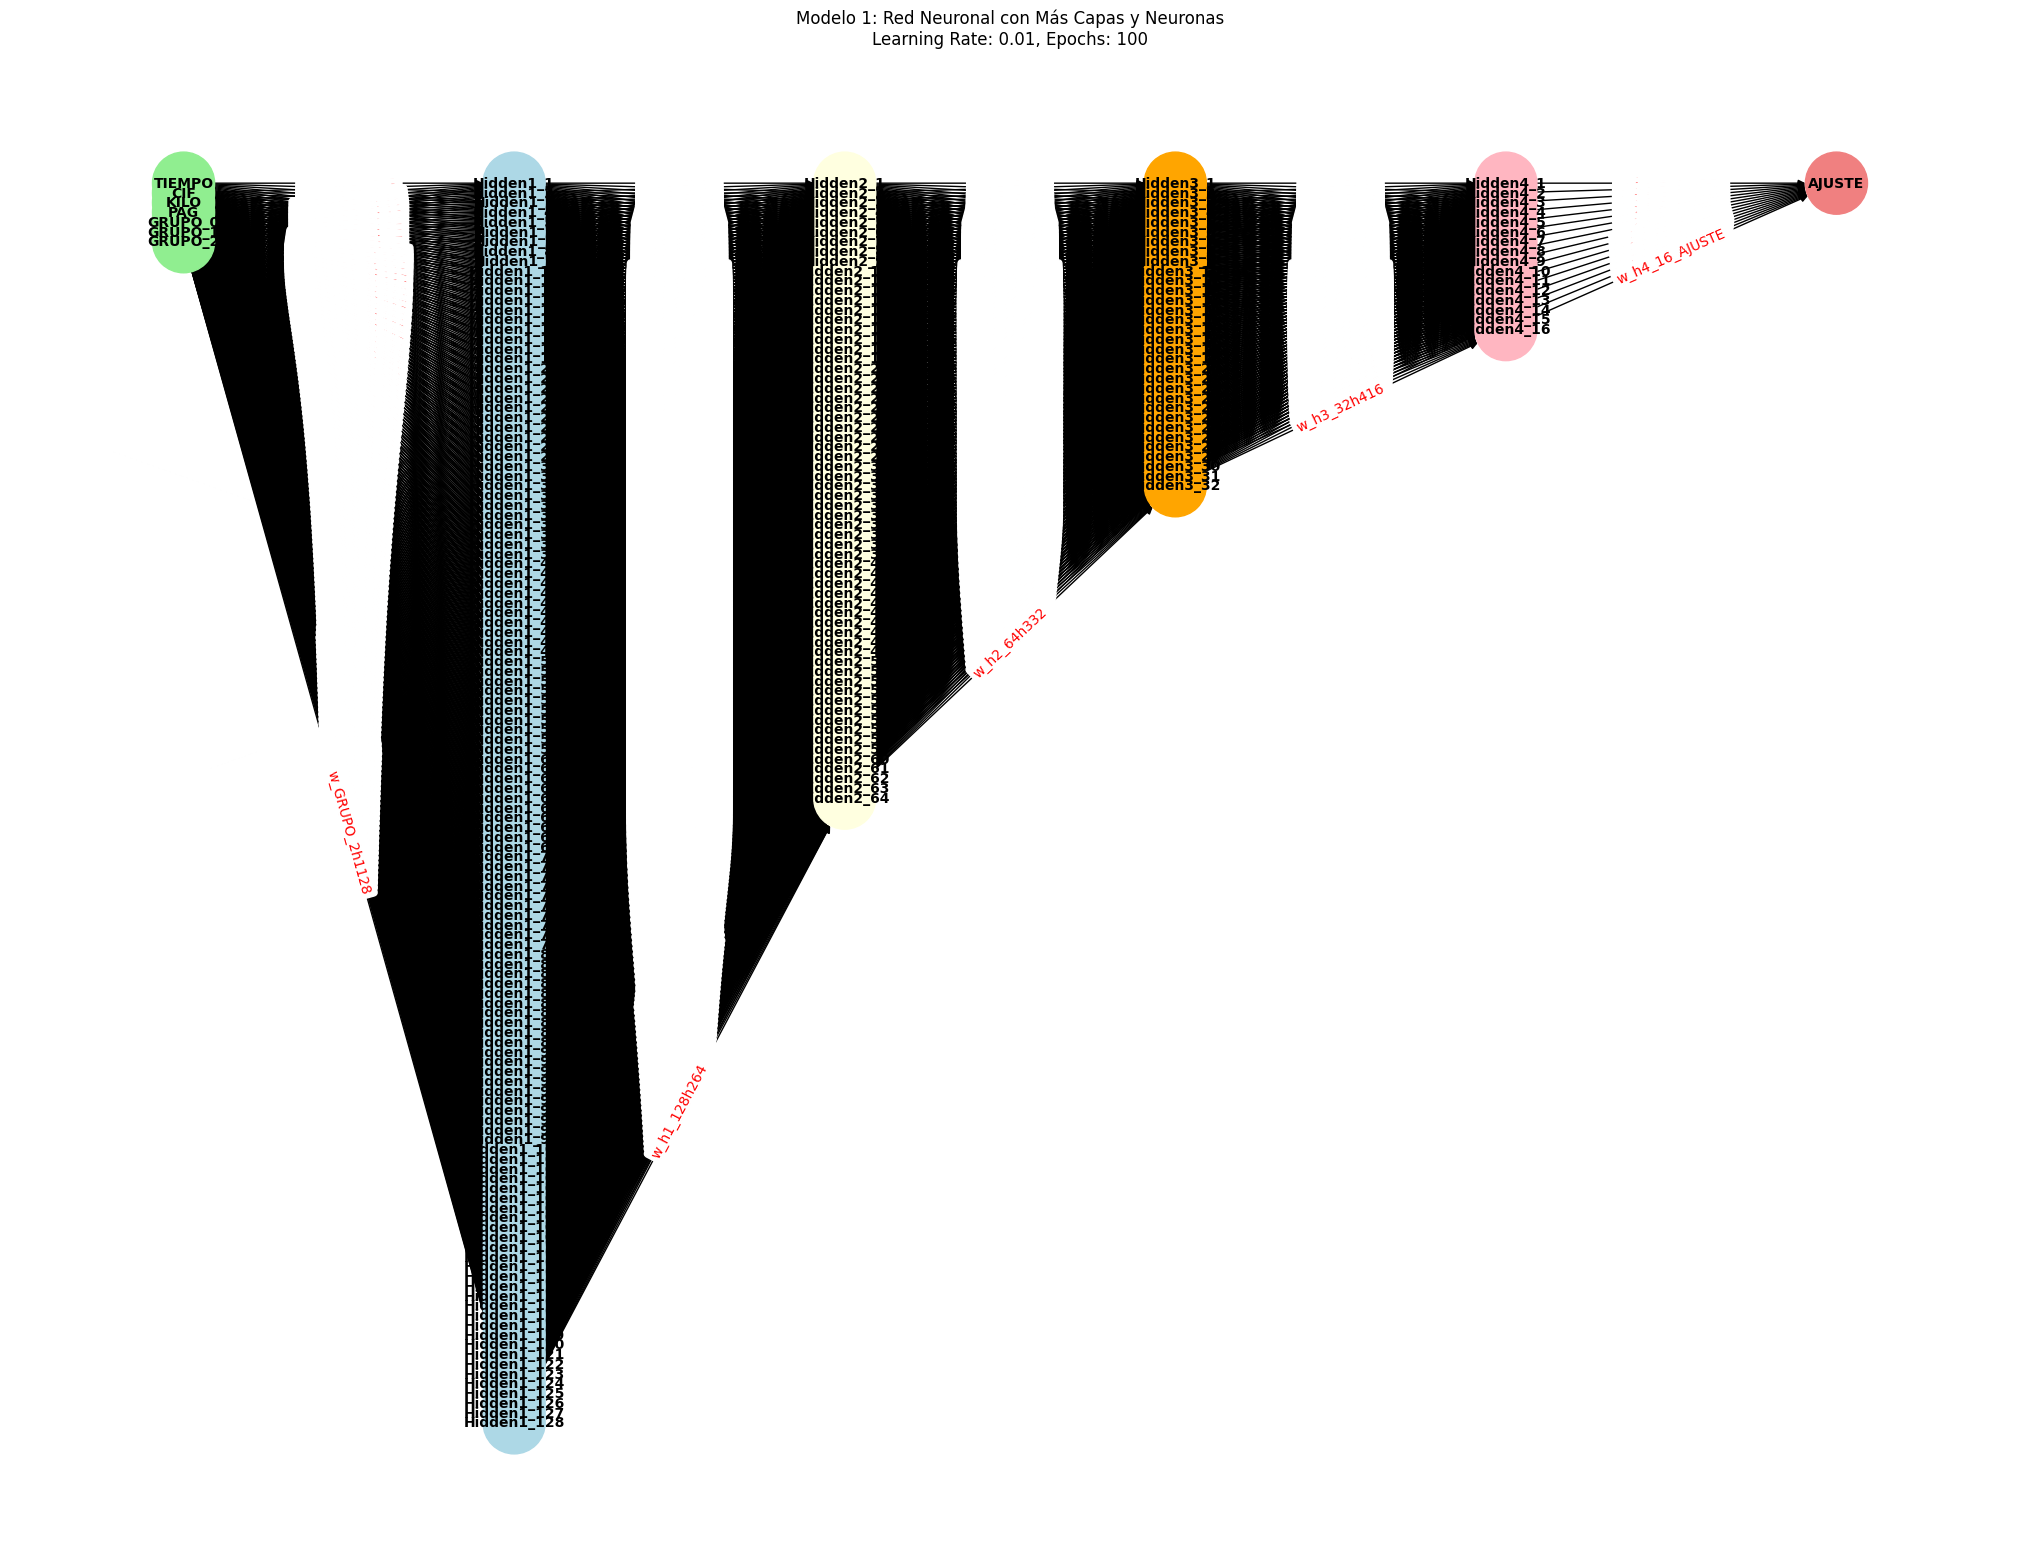

In [8]:
# GRAFICA Modelo 1 MLP CON MAS CAPAS Y NEURONAS (MULTICAPAS)
import matplotlib.pyplot as plt
import networkx as nx

# Definir las neuronas de entrada basadas en las características especificadas
input_features = ['TIEMPO', 'CIF', 'KILO', 'PAG', 'GRUPO_0', 'GRUPO_1', 'GRUPO_2']  # Ajustar según el número de categorías en GRUPO
hidden_neurons1 = 128
hidden_neurons2 = 64
hidden_neurons3 = 32
hidden_neurons4 = 16
output_neuron = 'AJUSTE'
learning_rate = 0.01
epochs = 100

# Crear el grafo
G = nx.DiGraph()

# Añadir nodos para la capa de entrada
for feature in input_features:
    G.add_node(feature, layer='input')

# Añadir nodos para las capas ocultas
for i in range(hidden_neurons1):
    G.add_node(f'Hidden1_{i+1}', layer='hidden1')

for i in range(hidden_neurons2):
    G.add_node(f'Hidden2_{i+1}', layer='hidden2')

for i in range(hidden_neurons3):
    G.add_node(f'Hidden3_{i+1}', layer='hidden3')

for i in range(hidden_neurons4):
    G.add_node(f'Hidden4_{i+1}', layer='hidden4')

# Añadir nodo para la capa de salida
G.add_node(output_neuron, layer='output')

# Conectar nodos de la capa de entrada a la primera capa oculta
for feature in input_features:
    for j in range(hidden_neurons1):
        G.add_edge(feature, f'Hidden1_{j+1}', weight=f'w_{feature}h1{j+1}')

# Conectar nodos de la primera capa oculta a la segunda capa oculta
for i in range(hidden_neurons1):
    for j in range(hidden_neurons2):
        G.add_edge(f'Hidden1_{i+1}', f'Hidden2_{j+1}', weight=f'w_h1_{i+1}h2{j+1}')

# Conectar nodos de la segunda capa oculta a la tercera capa oculta
for i in range(hidden_neurons2):
    for j in range(hidden_neurons3):
        G.add_edge(f'Hidden2_{i+1}', f'Hidden3_{j+1}', weight=f'w_h2_{i+1}h3{j+1}')

# Conectar nodos de la tercera capa oculta a la cuarta capa oculta
for i in range(hidden_neurons3):
    for j in range(hidden_neurons4):
        G.add_edge(f'Hidden3_{i+1}', f'Hidden4_{j+1}', weight=f'w_h3_{i+1}h4{j+1}')

# Conectar nodos de la cuarta capa oculta a la capa de salida
for i in range(hidden_neurons4):
    G.add_edge(f'Hidden4_{i+1}', output_neuron, weight=f'w_h4_{i+1}_{output_neuron}')

# Dibujar el grafo
pos = {}
pos.update((node, (0, -i)) for i, node in enumerate([n for n, d in G.nodes(data=True) if d['layer'] == 'input']))
pos.update((node, (1, -i)) for i, node in enumerate([n for n, d in G.nodes(data=True) if d['layer'] == 'hidden1']))
pos.update((node, (2, -i)) for i, node in enumerate([n for n, d in G.nodes(data=True) if d['layer'] == 'hidden2']))
pos.update((node, (3, -i)) for i, node in enumerate([n for n, d in G.nodes(data=True) if d['layer'] == 'hidden3']))
pos.update((node, (4, -i)) for i, node in enumerate([n for n, d in G.nodes(data=True) if d['layer'] == 'hidden4']))
pos.update((node, (5, -i)) for i, node in enumerate([n for n, d in G.nodes(data=True) if d['layer'] == 'output']))

plt.figure(figsize=(20, 15))

# Definir colores
node_colors = []
for node, data in G.nodes(data=True):
    if data['layer'] == 'input':
        node_colors.append('lightgreen')
    elif data['layer'] == 'hidden1':
        node_colors.append('lightblue')
    elif data['layer'] == 'hidden2':
        node_colors.append('lightyellow')
    elif data['layer'] == 'hidden3':
        node_colors.append('orange')
    elif data['layer'] == 'hidden4':
        node_colors.append('lightpink')
    else:
        node_colors.append('lightcoral')

nx.draw(G, pos, with_labels=True, node_size=2000, node_color=node_colors, font_size=10, font_weight='bold', arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['weight'] for u, v, d in G.edges(data=True)}, font_color='red')

plt.title(f'Modelo 1: Red Neuronal con Más Capas y Neuronas\nLearning Rate: {learning_rate}, Epochs: {epochs}')
plt.show()

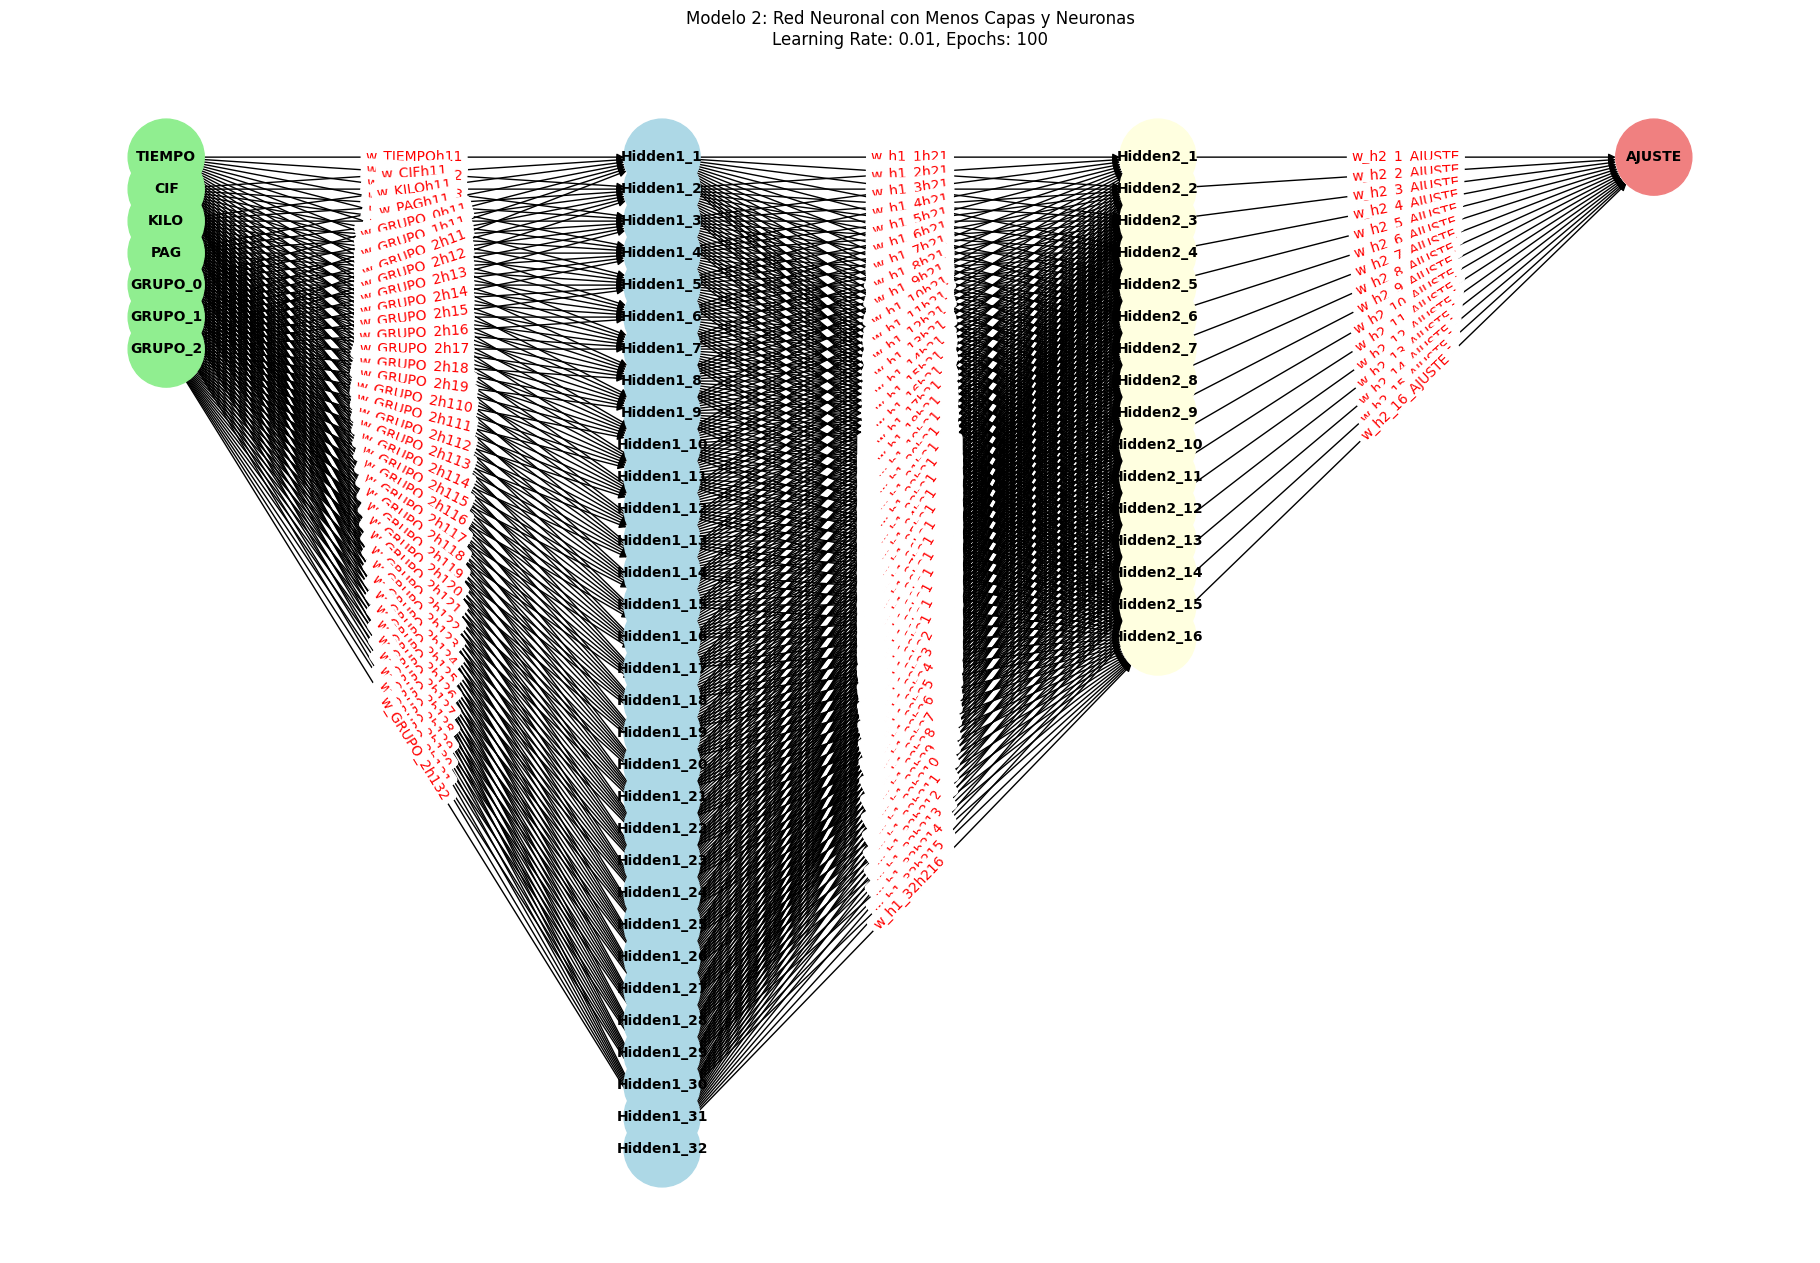

In [9]:
# GRAFICA Modelo 2 MLP CON MENOS CAPAS Y NEURONAS (MULTICAPAS)
import matplotlib.pyplot as plt
import networkx as nx

# Definir las neuronas de entrada basadas en las características especificadas
input_features = ['TIEMPO', 'CIF', 'KILO', 'PAG', 'GRUPO_0', 'GRUPO_1', 'GRUPO_2']  # Ajustar según el número de categorías en GRUPO
hidden_neurons1 = 32
hidden_neurons2 = 16
output_neuron = 'AJUSTE'
learning_rate = 0.01
epochs = 100

# Crear el grafo
G = nx.DiGraph()

# Añadir nodos para la capa de entrada
for feature in input_features:
    G.add_node(feature, layer='input')

# Añadir nodos para las capas ocultas
for i in range(hidden_neurons1):
    G.add_node(f'Hidden1_{i+1}', layer='hidden1')

for i in range(hidden_neurons2):
    G.add_node(f'Hidden2_{i+1}', layer='hidden2')

# Añadir nodo para la capa de salida
G.add_node(output_neuron, layer='output')

# Conectar nodos de la capa de entrada a la primera capa oculta
for feature in input_features:
    for j in range(hidden_neurons1):
        G.add_edge(feature, f'Hidden1_{j+1}', weight=f'w_{feature}h1{j+1}')

# Conectar nodos de la primera capa oculta a la segunda capa oculta
for i in range(hidden_neurons1):
    for j in range(hidden_neurons2):
        G.add_edge(f'Hidden1_{i+1}', f'Hidden2_{j+1}', weight=f'w_h1_{i+1}h2{j+1}')

# Conectar nodos de la segunda capa oculta a la capa de salida
for i in range(hidden_neurons2):
    G.add_edge(f'Hidden2_{i+1}', output_neuron, weight=f'w_h2_{i+1}_{output_neuron}')

# Dibujar el grafo
pos = {}
pos.update((node, (0, -i)) for i, node in enumerate([n for n, d in G.nodes(data=True) if d['layer'] == 'input']))
pos.update((node, (1, -i)) for i, node in enumerate([n for n, d in G.nodes(data=True) if d['layer'] == 'hidden1']))
pos.update((node, (2, -i)) for i, node in enumerate([n for n, d in G.nodes(data=True) if d['layer'] == 'hidden2']))
pos.update((node, (3, -i)) for i, node in enumerate([n for n, d in G.nodes(data=True) if d['layer'] == 'output']))

plt.figure(figsize=(18, 12))

# Definir colores
node_colors = []
for node, data in G.nodes(data=True):
    if data['layer'] == 'input':
        node_colors.append('lightgreen')
    elif data['layer'] == 'hidden1':
        node_colors.append('lightblue')
    elif data['layer'] == 'hidden2':
        node_colors.append('lightyellow')
    else:
        node_colors.append('lightcoral')

nx.draw(G, pos, with_labels=True, node_size=3000, node_color=node_colors, font_size=10, font_weight='bold', arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['weight'] for u, v, d in G.edges(data=True)}, font_color='red')

plt.title(f'Modelo 2: Red Neuronal con Menos Capas y Neuronas\nLearning Rate: {learning_rate}, Epochs: {epochs}')
plt.show()

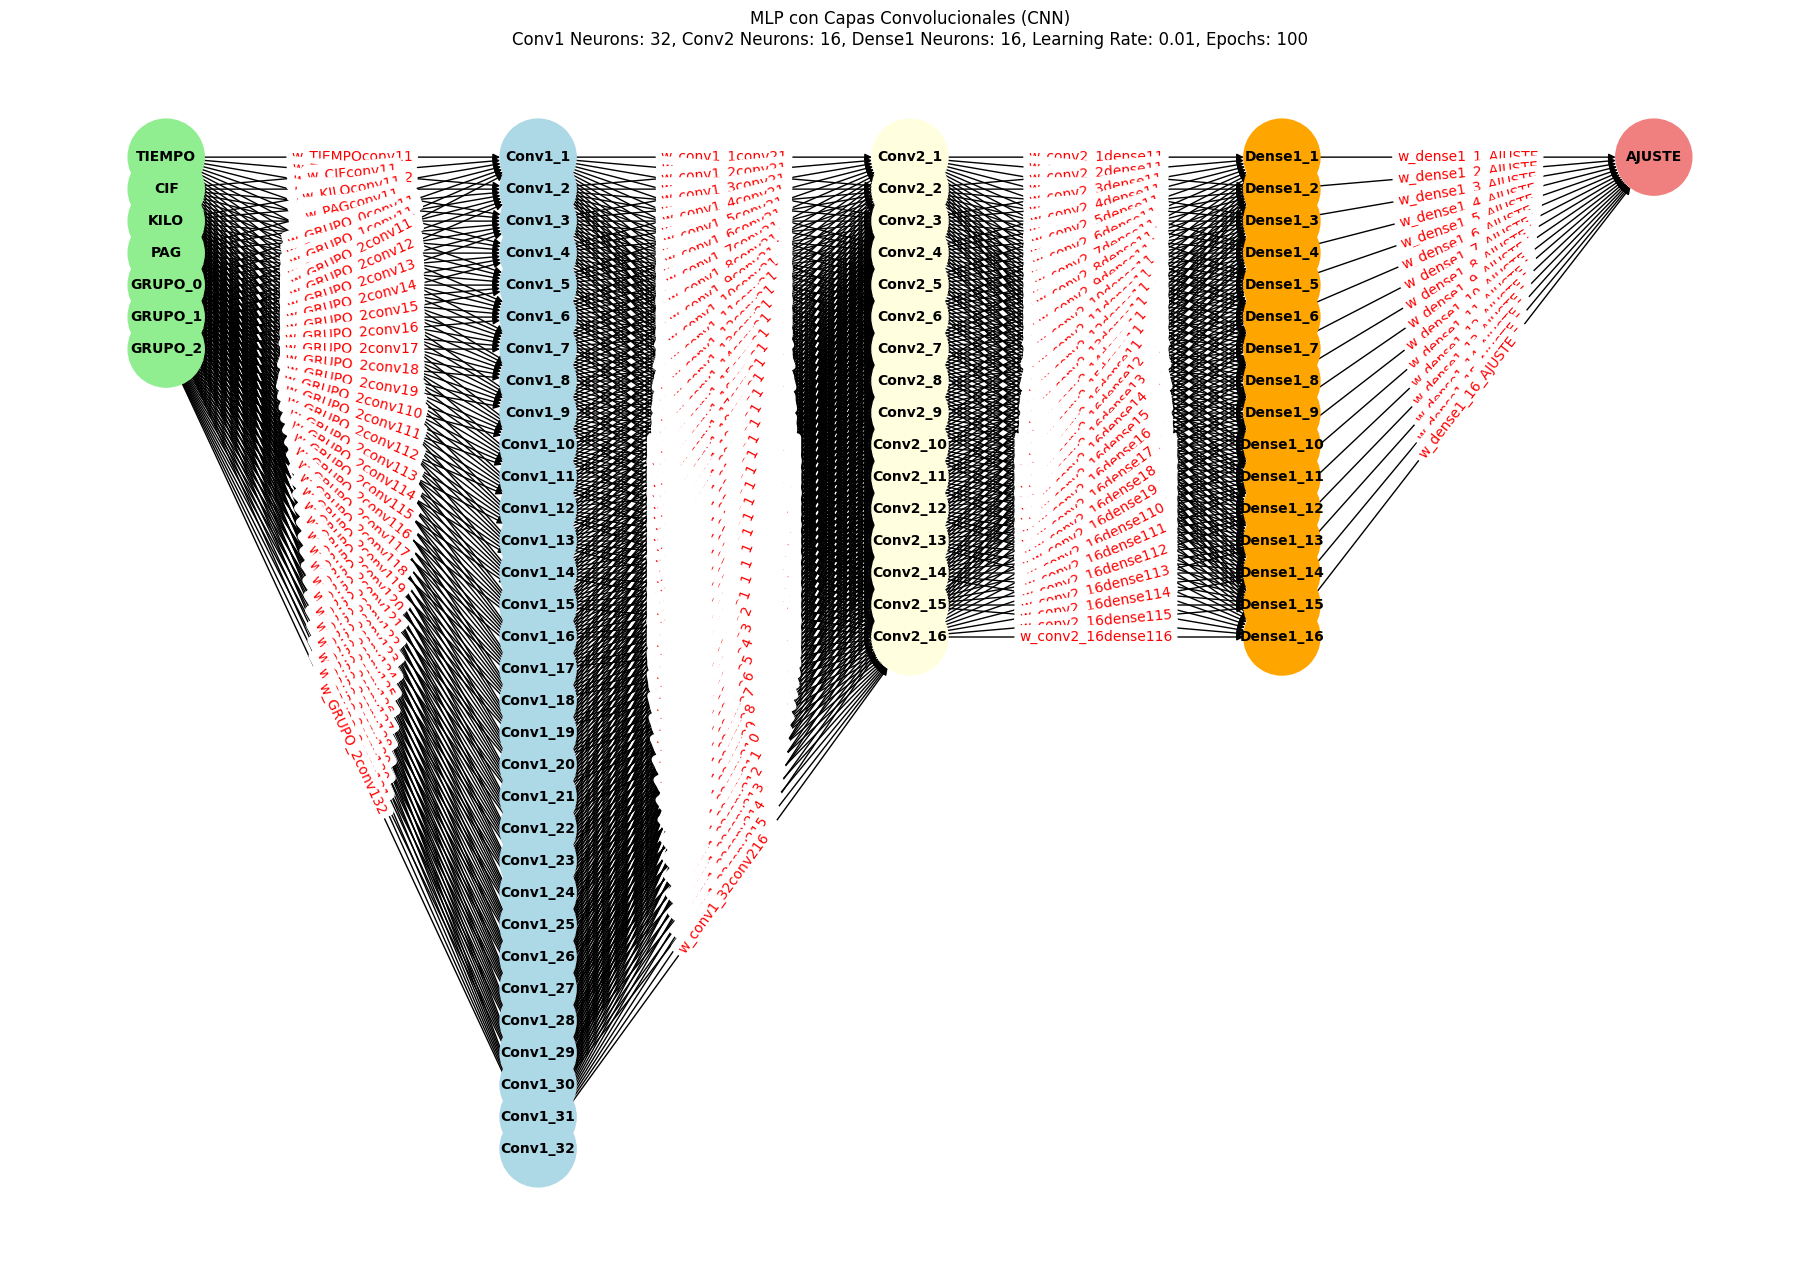

In [10]:
# GRAFICA Modelo 3 RED CONVOLUCIONAL 
import matplotlib.pyplot as plt
import networkx as nx

# Definir las neuronas de entrada basadas en las características especificadas
input_features = ['TIEMPO', 'CIF', 'KILO', 'PAG', 'GRUPO_0', 'GRUPO_1', 'GRUPO_2']  # Ajustar según el número de categorías en GRUPO
conv1_neurons = 32
conv2_neurons = 16
dense1_neurons = 16
output_neuron = 'AJUSTE'
learning_rate = 0.01
epochs = 100

# Crear el grafo
G = nx.DiGraph()

# Añadir nodos para la capa de entrada
for feature in input_features:
    G.add_node(feature, layer='input')

# Añadir nodos para la primera capa convolucional
for i in range(conv1_neurons):
    G.add_node(f'Conv1_{i+1}', layer='conv1')

# Añadir nodos para la segunda capa convolucional
for i in range(conv2_neurons):
    G.add_node(f'Conv2_{i+1}', layer='conv2')

# Añadir nodos para la primera capa densa
for i in range(dense1_neurons):
    G.add_node(f'Dense1_{i+1}', layer='dense1')

# Añadir nodo para la capa de salida
G.add_node(output_neuron, layer='output')

# Conectar nodos de la capa de entrada a la primera capa convolucional
for feature in input_features:
    for j in range(conv1_neurons):
        G.add_edge(feature, f'Conv1_{j+1}', weight=f'w_{feature}conv1{j+1}')

# Conectar nodos de la primera capa convolucional a la segunda capa convolucional
for i in range(conv1_neurons):
    for j in range(conv2_neurons):
        G.add_edge(f'Conv1_{i+1}', f'Conv2_{j+1}', weight=f'w_conv1_{i+1}conv2{j+1}')

# Conectar nodos de la segunda capa convolucional a la primera capa densa
for i in range(conv2_neurons):
    for j in range(dense1_neurons):
        G.add_edge(f'Conv2_{i+1}', f'Dense1_{j+1}', weight=f'w_conv2_{i+1}dense1{j+1}')

# Conectar nodos de la primera capa densa a la capa de salida
for i in range(dense1_neurons):
    G.add_edge(f'Dense1_{i+1}', output_neuron, weight=f'w_dense1_{i+1}_{output_neuron}')

# Dibujar el grafo
pos = {}
pos.update((node, (0, -i)) for i, node in enumerate([n for n, d in G.nodes(data=True) if d['layer'] == 'input']))
pos.update((node, (1, -i)) for i, node in enumerate([n for n, d in G.nodes(data=True) if d['layer'] == 'conv1']))
pos.update((node, (2, -i)) for i, node in enumerate([n for n, d in G.nodes(data=True) if d['layer'] == 'conv2']))
pos.update((node, (3, -i)) for i, node in enumerate([n for n, d in G.nodes(data=True) if d['layer'] == 'dense1']))
pos.update((node, (4, -i)) for i, node in enumerate([n for n, d in G.nodes(data=True) if d['layer'] == 'output']))

plt.figure(figsize=(18, 12))

# Definir colores
node_colors = []
for node, data in G.nodes(data=True):
    if data['layer'] == 'input':
        node_colors.append('lightgreen')
    elif data['layer'] == 'conv1':
        node_colors.append('lightblue')
    elif data['layer'] == 'conv2':
        node_colors.append('lightyellow')
    elif data['layer'] == 'dense1':
        node_colors.append('orange')
    else:
        node_colors.append('lightcoral')

nx.draw(G, pos, with_labels=True, node_size=3000, node_color=node_colors, font_size=10, font_weight='bold', arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['weight'] for u, v, d in G.edges(data=True)}, font_color='red')

plt.title(f'MLP con Capas Convolucionales (CNN)\nConv1 Neurons: {conv1_neurons}, Conv2 Neurons: {conv2_neurons}, Dense1 Neurons: {dense1_neurons}, Learning Rate: {learning_rate}, Epochs: {epochs}')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
    AJUSTE  TIEMPO    CIF   KILO      PAG  GRUPO  Prediccion_Ajuste  \
0        0      28  19803  15414  1980.30      1        1518.193604   
1        0      25  11278  13948  1691.70      0         528.434998   
2        0      25   7678   1500  1456.00     -1          15.162916   
3        0      33  23035   4502  4607.00      1        9226.882812   
4        0      29  15040   2976  1804.80      1         894.812622   
5        0      23  21944  18681  5266.56     -1       10897.291016   
6        0      22  21500   2614  6450.00      0       14324.459961   
7        0      26  14823  16380  1482.30      0          73.812363   
8        0      20  11007  10312  1651.05     -1         391.600708   
9        0      16  10500   1600  2500.00      1        2708.215820   
10       0      22   1356    123   245.00      1          13.391321   
11       0      14  11789   1090  1500.00      1          82.753708   
12       0      17   4567    479   456.

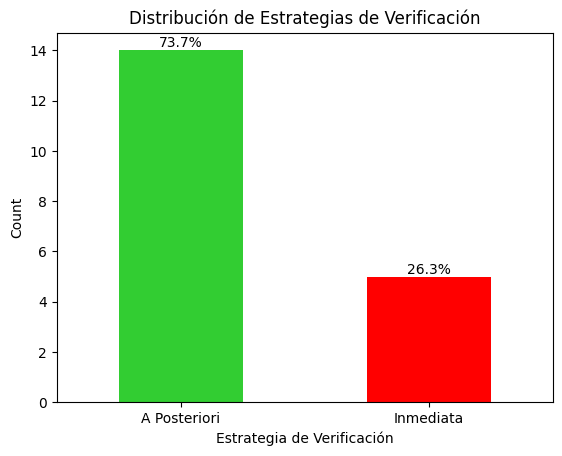

In [17]:
## Implementacion del MODELO 2 MLP MULTICAS y ESTRATEGIA DE INSPECCION A NUEVAS OPERACIONES ADUANERA
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt

# Rutas
input_excel_path = "C:/Mae_BI_UAM/M13/RN_Final/Evasion3/data/Nuevas_duca.xlsx"
output_excel_path = "C:/Mae_BI_UAM/M13/RN_Final/Evasion3/data/Perfilamiento_duca.xlsx"
model_path = "C:/Mae_BI_UAM/M13/RN_Final/Evasion3/data/Modelo2.h5"

# Cargar el modelo entrenado
try:
    model = tf.keras.models.load_model(model_path)
except FileNotFoundError:
    raise FileNotFoundError(f"No se pudo encontrar el archivo {model_path}. Verifica la ruta y el nombre del archivo.")

# Cargar el dataframe Nueva_duca desde Excel
nueva_duca = pd.read_excel(input_excel_path)

# Preprocesamiento similar al entrenamiento
X_new = nueva_duca.drop(columns=['AJUSTE'])  # Ajustar según las columnas reales
scaler = StandardScaler()
X_new_scaled = scaler.fit_transform(X_new)

# Realizar predicciones
predictions = model.predict(X_new_scaled)

# Agregar las predicciones al DataFrame
nueva_duca['Prediccion_Ajuste'] = predictions.flatten()

# Aplicar la estrategia de verificación
nueva_duca['Estrategia_Verificacion'] = np.where(
    (nueva_duca['Prediccion_Ajuste'] > 1000) & (nueva_duca['CIF'] > 3500),
    'Verificacion_Inmediata',
    'Verificacion_a_Posteriori'
)

# Guardar los resultados en un nuevo archivo Excel
nueva_duca.to_excel(output_excel_path, index=False)

# Cargar el DataFrame Perfilamiento_duca desde el archivo generado
perfilamiento_duca = pd.read_excel(output_excel_path)

# Imprimir todos los registros de Perfilamiento_duca
print(perfilamiento_duca)

# Contar los grupos en la variable Estrategia_Verificacion
estrategia_counts = perfilamiento_duca['Estrategia_Verificacion'].value_counts()
total = estrategia_counts.sum()

# Calcular el porcentaje de participación de cada grupo
estrategia_percentages = (estrategia_counts / total) * 100

# Crear una tabla con los resultados
estrategia_table = pd.DataFrame({
    'Count': estrategia_counts,
    'Percentage': estrategia_percentages
})

# Imprimir la tabla
print(estrategia_table)

# Renombrar los índices para la gráfica
estrategia_counts.index = estrategia_counts.index.str.replace('Verificacion_a_Posteriori', 'A Posteriori')
estrategia_counts.index = estrategia_counts.index.str.replace('Verificacion_Inmediata', 'Inmediata')

# Generar la gráfica de barras
colors = {'A Posteriori': 'limegreen', 'Inmediata': 'red'}
ax = estrategia_counts.plot(kind='bar', color=[colors[label] for label in estrategia_counts.index])

# Ajustar las etiquetas del eje x para que se muestren de forma horizontal
plt.xticks(rotation=0)

# Añadir etiquetas y título
plt.xlabel('Estrategia de Verificación')
plt.ylabel('Count')
plt.title('Distribución de Estrategias de Verificación')

# Añadir porcentaje encima de las barras
for i, (count, percentage) in enumerate(zip(estrategia_counts, estrategia_percentages)):
    plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

# Mostrar la gráfica
plt.show()